# Analysis of matched pairs using ILUAii data

In [1]:
library(tidyverse)
library(vegan)
library(cowplot)
library(MetBrewer)

── Attaching packages ─────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-2



In [2]:
path <- '/exports/csce/datastore/geos/users/s0834538/pa_matching_data/'

In [3]:
##read in the plots and stems from ILUAii data
plots <- read_csv(paste0(path,'iluaii/plots.csv'), show_col_types = FALSE)
stems <- read_csv(paste0(path,'iluaii/stems.csv'), show_col_types = FALSE)

In [4]:
##read in the apirwise distnace measures (malhanbois distnace and difference in p score) 
mdists <- read_csv('data/M_dists_all_all.csv', show_col_types = FALSE) # mhalbonis distance between pairs
dpscore <- read_csv('data/dif_pscore_all_all.csv', show_col_types = FALSE)
pscore <- read_csv('data/pscore_all_all.csv', show_col_types = FALSE)

New names:
* `` -> ...1

New names:
* `` -> ...1

New names:
* `` -> ...1



In [ ]:
##read in match data 
psm <- read_csv('data/PSM_matched_data_all.csv', show_col_types = FALSE) 
psm2 <- read_csv('data/PSM_no_clpr_matched_data_all.csv', show_col_types = FALSE) 
mdm <- read_csv('data/MDM_matched_data_all.csv', show_col_types = FALSE) 
unm <- read_csv('data/unmatched_data_clusters.csv', show_col_types = FALSE) %>% 
                                    mutate(treatment = treat_all) #, other = fr + other_pa) %>%  #set treatment as being in a national park or gma
                                       # filter(treatment == 1 | other == 0) %>% ##remvoe points in the other types of PA
                                       #   filter(treatment == 1 | spill10_np_gma == 0) # remove

In [ ]:
##calcuate Pscore for all units
pscore_all <- match.data(PSM_match, data = data, distance = "pscore", drop.unmatched = FALSE) %>%
                        select(pscore) 

In [ ]:
##pairwise difference in p_score for all pixels (ignoring treatment)
dif_pscore_all <- dist(pscore_all, method = 'euclidean') %>% as.matrix()

In [ ]:
pscore_all <- pscore_all %>% rownames_to_column(var = "plot_cluster")

In [ ]:
##list of matched pairs
psm_pairs <- PSM_match$match.matrix %>% 
                as.data.frame() %>%
                 drop_na() %>%
                rownames_to_column(var = "treat_cluster") %>%
                rename('control_cluster'='V1') %>%
                left_join(pscore_all, by = c('treat_cluster' = 'plot_cluster')) %>%
                left_join(pscore_all, by = c('control_cluster' = 'plot_cluster')) %>%
                mutate(dpscore = abs(pscore.x - pscore.y))

In [ ]:
##list of matched pairs
psm_pairs2 <- PSM_match2$match.matrix %>% 
                as.data.frame() %>%
                 drop_na() %>%
                rownames_to_column(var = "treat_cluster") %>%
                rename('control_cluster'='V1') %>%
                left_join(pscore_all, by = c('treat_cluster' = 'plot_cluster')) %>%
                left_join(pscore_all, by = c('control_cluster' = 'plot_cluster')) %>%
                mutate(dpscore = abs(pscore.x - pscore.y))

In [ ]:
write.csv(pscore_all, 'data/pscore_all.csv')
write.csv(dif_pscore_all, 'data/dif_pscore_all.csv')
write.csv(psm_pairs, 'data/dif_pscore_matched_all.csv')
write.csv(psm_pairs2, 'data/dif_pscore_matched_no_clpr_all.csv')

In [ ]:
#Malhanobis distances will be slighly different if competed compeltely pairwise or treatment verus control 
#pairwise Malhanbois for all pixels (ignoring treatment)
#This returns the sqaured Malhanbois distance so take square root
data2 <- data %>% select(all_of(conf)) ## remove the non-covar columns

mdm_all <- full(distance(data2, method = "mahalanobis")) ^ 0.5 %>% as.matrix()

In [ ]:
##put the plot_cluster id as the row and colmn names
rownames(mdm_all) <- rownames(data)
colnames(mdm_all) <- rownames(data)

In [ ]:
##Malhanobis comapring treatment and controls - 
#this is slightly differnet comapred to mal dist for all possible pariwise combinations
mdm_trt_con <- optmatch::match_on(formula, data = data, method = "mahalanobis")

In [ ]:
mdm_trt_con['ZIS_975', 'ZIS_1']
mdm_all['ZIS_975', 'ZIS_1']

[1] 2.808283

[1] 2.805037

In [ ]:
##get mal distnace for matched pairs
mdist_long <- mdm_trt_con %>% 
               as.data.frame() %>%
                rownames_to_column(var = "treat_cluster") %>%
                pivot_longer(cols = where(is.numeric), values_to = 'm_dist', names_to = 'control_cluster')    

In [ ]:
##list of matched pairs and join the malhanbois distances
mdm_pairs <- MDM_match$match.matrix %>% 
                as.data.frame() %>%
                drop_na() %>%
                rownames_to_column(var = "treat_cluster") %>%
                rename('control_cluster'='V1') %>%
                left_join(mdist_long, by = c('treat_cluster', 'control_cluster'))

In [ ]:
##list of matched pairs and join the malhanbois distances
mdm_pairs2 <- MDM_match2$match.matrix %>% 
                as.data.frame() %>%
                drop_na() %>%
                rownames_to_column(var = "treat_cluster") %>%
                rename('control_cluster'='V1') %>%
                left_join(mdist_long, by = c('treat_cluster', 'control_cluster'))

In [ ]:
write.csv(mdm_all, 'data/M_dists_all.csv')
write.csv(mdm_trt_con, 'data/M_dists_trt_con_all.csv')
write.csv(mdm_pairs, 'data/M_dists_matched_all.csv')
write.csv(mdm_pairs2, 'data/M_dists_matched_no_clpr_all.csv')

In [ ]:
##read in the distnaces for the matched dataset
psm_pairs <- read_csv('data/dif_pscore_matched.csv', show_col_types = FALSE) 
psm_pairs2 <- read_csv('data/dif_pscore_matched_no_clpr.csv', show_col_types = FALSE)
mdm_pairs <- read_csv('data/M_dists_matched.csv', show_col_types = FALSE) 

In [ ]:
table(unm$treatment)

In [ ]:
##create 1000 random datasets for comparrison

randoms <- data.frame()

for (i in 1:1000) {
        j = runif(1, 25, 231) #randomly select the nubmer of matched pairs max is totla nubmer of treated min is > 10% of max
        df <- unm %>% 
                    group_by(treatment) %>% 
                    sample_n(j) %>%
                    mutate(subclass = seq(1:j)) %>%
                    ungroup() %>% mutate(dataset = paste0('dataset',i))
        randoms <- bind_rows(randoms, df)
}

In [ ]:
##get pairs for randomised datasets
ran_pairs <- randoms %>%
                group_by(dataset, subclass) %>%
                    select(dataset, subclass, treatment, plot_cluster) %>%
                    pivot_wider(names_from ='treatment', values_from ='plot_cluster') %>%
                    rename('treat_cluster' = '1', 'control_cluster' = '0') %>%
                    unite('pair', treat_cluster:control_cluster, sep = '_', remove = FALSE)

In [ ]:
##calculate plot measures at the cluster scale
pm <- plots %>% 
                select(plot_cluster, stocking_ha, ba_ha, diam_mean) %>%
                group_by(plot_cluster) %>%
                summarize(across(stocking_ha:diam_mean, ~ mean(.x, na.rm = TRUE))) %>%
                mutate(across(everything(), ~replace(., is.na(.), 0))) 

In [ ]:
##select only distinct treees from the stems dataset - aovids inflated abudances
trees <- stems %>%
            select(plot_id, tree_id, species_name_clean) %>%
            distinct(tree_id, .keep_all = TRUE)

In [ ]:
##make a community matrix
sp_mat <- plots %>%
            select(plot_id, plot_cluster) %>%
            left_join(trees, by = 'plot_id') %>%
            group_by(plot_cluster, species_name_clean) %>%
            summarize(count = length(species_name_clean)) %>%
            ungroup() %>%
            pivot_wider(names_from = 'species_name_clean', values_from = 'count') %>%
            mutate(across(everything(), ~replace(., is.na(.), 0))) %>%
            column_to_rownames(var = "plot_cluster") %>%
            select(-'NA')

In [ ]:
##calcualte simpsons and shannon indexes
shannon <- diversity(sp_mat, index = "shannon") 
#simpson <- diversity(sp_mat, index = "simpson") 

In [ ]:
##calcuate richenss as sum of species
richness <- sp_mat %>% 
            rownames_to_column(var = "plot_cluster") %>%
            mutate(across(where(is.numeric), ~replace(., . > 0, 1))) %>%
            transmute(plot_cluster, richness = rowSums(across(where(is.numeric)))) 

In [ ]:
##convert to dataframes
shannon_df <- as.data.frame(shannon) %>% 
                rownames_to_column(var = "plot_cluster")

#simpson_df <- as.data.frame(simpson) %>% 
   #            rownames_to_column(var = "plot_cluster")

In [ ]:
##calculate plot measures of species at the cluster scale
pm_sp <- richness %>%
            left_join(shannon_df, by = 'plot_cluster') #%>%
          #  left_join(simpson_df, by = 'plot_cluster')

In [ ]:
#read in table of high vlaue tree species from Zambia
hv_trees <- read_csv('data/high_value_trees.csv', show_col_types = FALSE)

In [ ]:
##filter to jsut those with an extractive use - timber of charcol
hv_extract <- hv_trees %>% 
                filter(str_detect(Major_use, c('Timber','Charcoal')))

In [ ]:
##as a list
hve_sp <- hv_extract$Species

In [ ]:
##number of high vlaue extractive speceis in a plot
pm_hve_sp <- trees %>%
                filter(species_name_clean %in% hve_sp) %>%
                left_join(select(plots, plot_cluster, plot_id), by = 'plot_id') %>%
                group_by(plot_cluster) %>%
                summarize(hve_sp = length(species_name_clean))

In [ ]:
##join all plot measurments together
plt_ms <- pm %>% 
            left_join(pm_sp, by = 'plot_cluster') %>%
            left_join(pm_hve_sp, by = 'plot_cluster') %>%
            mutate(hve_sp = ifelse(is.na(hve_sp), 0, hve_sp)) 

In [ ]:
##mean standerize the plot measurements so 1 = 1 sd, mean = 0
pm_stand <- plt_ms %>%
                     mutate(across(.cols = stocking_ha:hve_sp, ~ (.x - mean(.x, na.rm = TRUE)) / sd(.x, na.rm = TRUE)))

In [ ]:
##plot distrubtion of plot measurments in treamaent and control
pm_long <- unm %>% 
            select(plot_cluster, treatment) %>%
            left_join(plt_ms, by = 'plot_cluster') %>%
            pivot_longer(stocking_ha:hve_sp, names_to = 'var', values_to = 'value') %>%
            mutate(treatment = as.factor(treatment))

In [ ]:
##chosoe pallette
pal <- as.list(met.brewer('Hiroshige'))

In [ ]:
options(repr.plot.width=4, repr.plot.height=4)
met.brewer('Hiroshige')

In [ ]:
options(repr.plot.width=20, repr.plot.height=10)

(var_comp_plt <- ggplot(pm_long) +
                     geom_density(aes(value, fill = treatment), alpha = 0.7) +
                     facet_wrap(~var, scales = 'free') +
                     scale_fill_manual(values = c(pal[2],pal[8]), labels = c('Control', 'Treatment')) +
                     theme_cowplot() +
                     theme(text = element_text(size = 18),  
                     axis.title=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(.9,.3), legend.title = element_blank())
)

In [ ]:
ggsave(var_comp_plt, 'png', filename = 'figures/pm_plt.png', width = 20, height = 10)

 # Beta Diversity

In [ ]:
##caclaute beta diverity for all plots pairwise
beta_all <-  sp_mat %>%
                vegdist(., method="bray") %>%
                as.matrix()

In [ ]:
psm_beta <- beta_all[psm_pairs$treat_cluster,psm_pairs$control_cluster] 
psm2_beta <- beta_all[psm_pairs2$treat_cluster,psm_pairs2$control_cluster] 
mdm_beta <- beta_all[mdm_pairs$treat_cluster,mdm_pairs$control_cluster] 

In [ ]:
##remvoe the duplciate values from the top half of the diagonal
beta_all[upper.tri(beta_all, diag = TRUE)] <- NA

In [ ]:
##convert to a long form df
beta_all_df <- beta_all %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'bray_curtis') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'Unmatched')

In [ ]:
##convert to a long form df
beta_psm_df <- psm_beta %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'bray_curtis') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'PSM')

In [ ]:
##convert to a long form df
beta_psm2_df <- psm2_beta %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'bray_curtis') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'PSM2')

In [ ]:
##convert to a long form df
beta_mdm_df <- mdm_beta %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'bray_curtis') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'MDM')

In [ ]:
beta_comp <- bind_rows(beta_all_df, beta_psm_df, beta_psm2_df, beta_mdm_df)

In [36]:
beta_comp_plt <-  ggplot() +
                     geom_histogram(data = beta_comp, aes(bray_curtis, fill = dataset)) +
                         theme_cowplot() +
                         facet_wrap(~dataset, scales = 'free_y') +
                     scale_fill_manual(values = c(pal[1], pal[3], pal[4], pal[8])) +
                     labs(x= 'Bray Curtis index') +
                     theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = 'none', legend.title = element_blank())

In [37]:
beta_comp_boxplt <-  ggplot() +
                     geom_boxplot(data = beta_comp, aes((bray_curtis), dataset, fill = dataset)) +
                     theme_cowplot() +
                     scale_fill_manual(values = c(pal[1], pal[3], pal[4], pal[8])) +
                     labs(x= 'Bray Curtis index') +
                     theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = 'none', legend.title = element_blank())


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



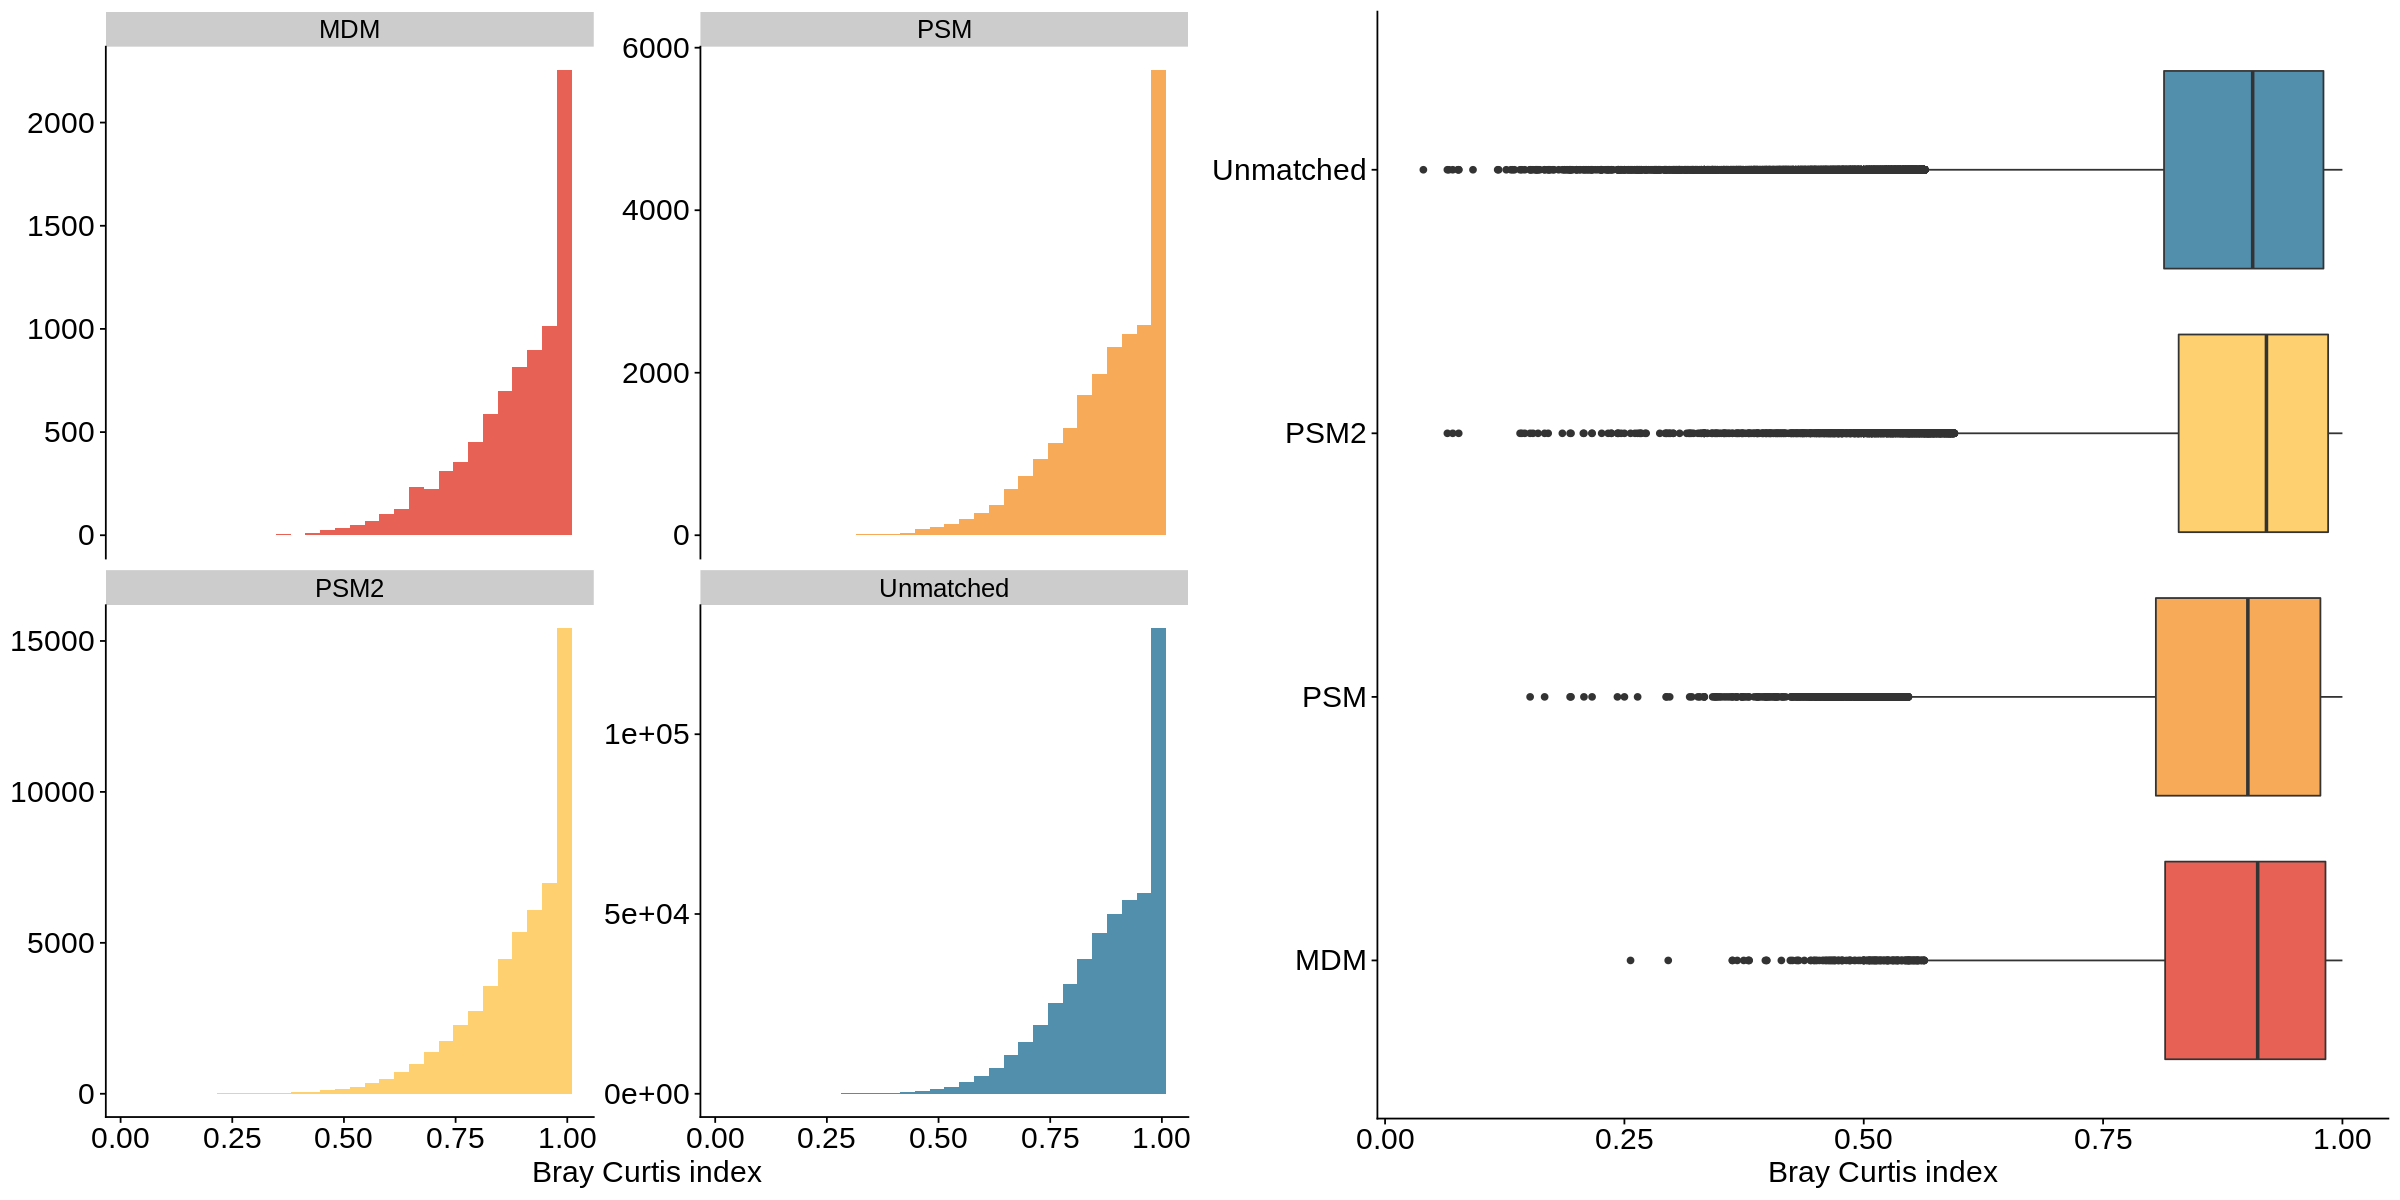

In [38]:
options(repr.plot.width=20, repr.plot.height=10)

beta_grid <-  plot_grid(beta_comp_plt, beta_comp_boxplt)
beta_grid

In [39]:
#ggsave(beta_grid, 'png', filename = 'figures/beta_plt_np.png', width = 20, height = 10)

## Matching distance measures - all pairwise 

In [40]:
##remove the duplciate values from the top half of the diagonal
dpscore2 <- dpscore %>% column_to_rownames(var = "...1") %>% as.matrix()
dpscore2[upper.tri(dpscore2, diag = TRUE)] <- NA

In [41]:
##convert to a long form df
dpscore_df <- dpscore2 %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'distance') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'Unmatched dif pscore')

In [42]:
##remvoe the duplciate values from the top half of the diagonal
mdists2 <- mdists %>% column_to_rownames(var = "...1") %>% as.matrix()
mdists2[upper.tri(mdists2, diag = TRUE)] <- NA

In [43]:
##convert to a long form df
m_dist_df <- mdists2 %>% 
                as.data.frame() %>% 
                rownames_to_column('cluster1')%>%
                pivot_longer(cols = contains('Z'), names_to = 'cluster2', values_to = 'distance') %>%
                unite('pair', cluster1:cluster2, sep = '_', remove = FALSE) %>%
                drop_na() %>%
                mutate(dataset = 'Unmatched Mdist')

In [44]:
unm_dist_df <- bind_rows(m_dist_df, dpscore_df) 

## Distances in the Matched datasets

In [45]:
mdm_pairs <- mdm_pairs %>%
                    mutate(distance = m_dist, dataset = 'MDM') %>%
                    select(treat_cluster, control_cluster, distance, dataset)

In [46]:
psm_pairs <- psm_pairs %>%
                    mutate(distance = dpscore, dataset = 'PSM') %>%
                    select(treat_cluster, control_cluster, distance, dataset)

In [47]:
psm_pairs2 <- psm_pairs2 %>%
                    mutate(distance = dpscore, dataset = 'PSM2') %>%
                    select(treat_cluster, control_cluster, distance, dataset)

In [48]:
pairs <- bind_rows(mdm_pairs, psm_pairs, psm_pairs2)

In [49]:
dist <- pairs %>%
            select(distance, dataset) %>%
            bind_rows(select(unm_dist_df, distance, dataset))

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



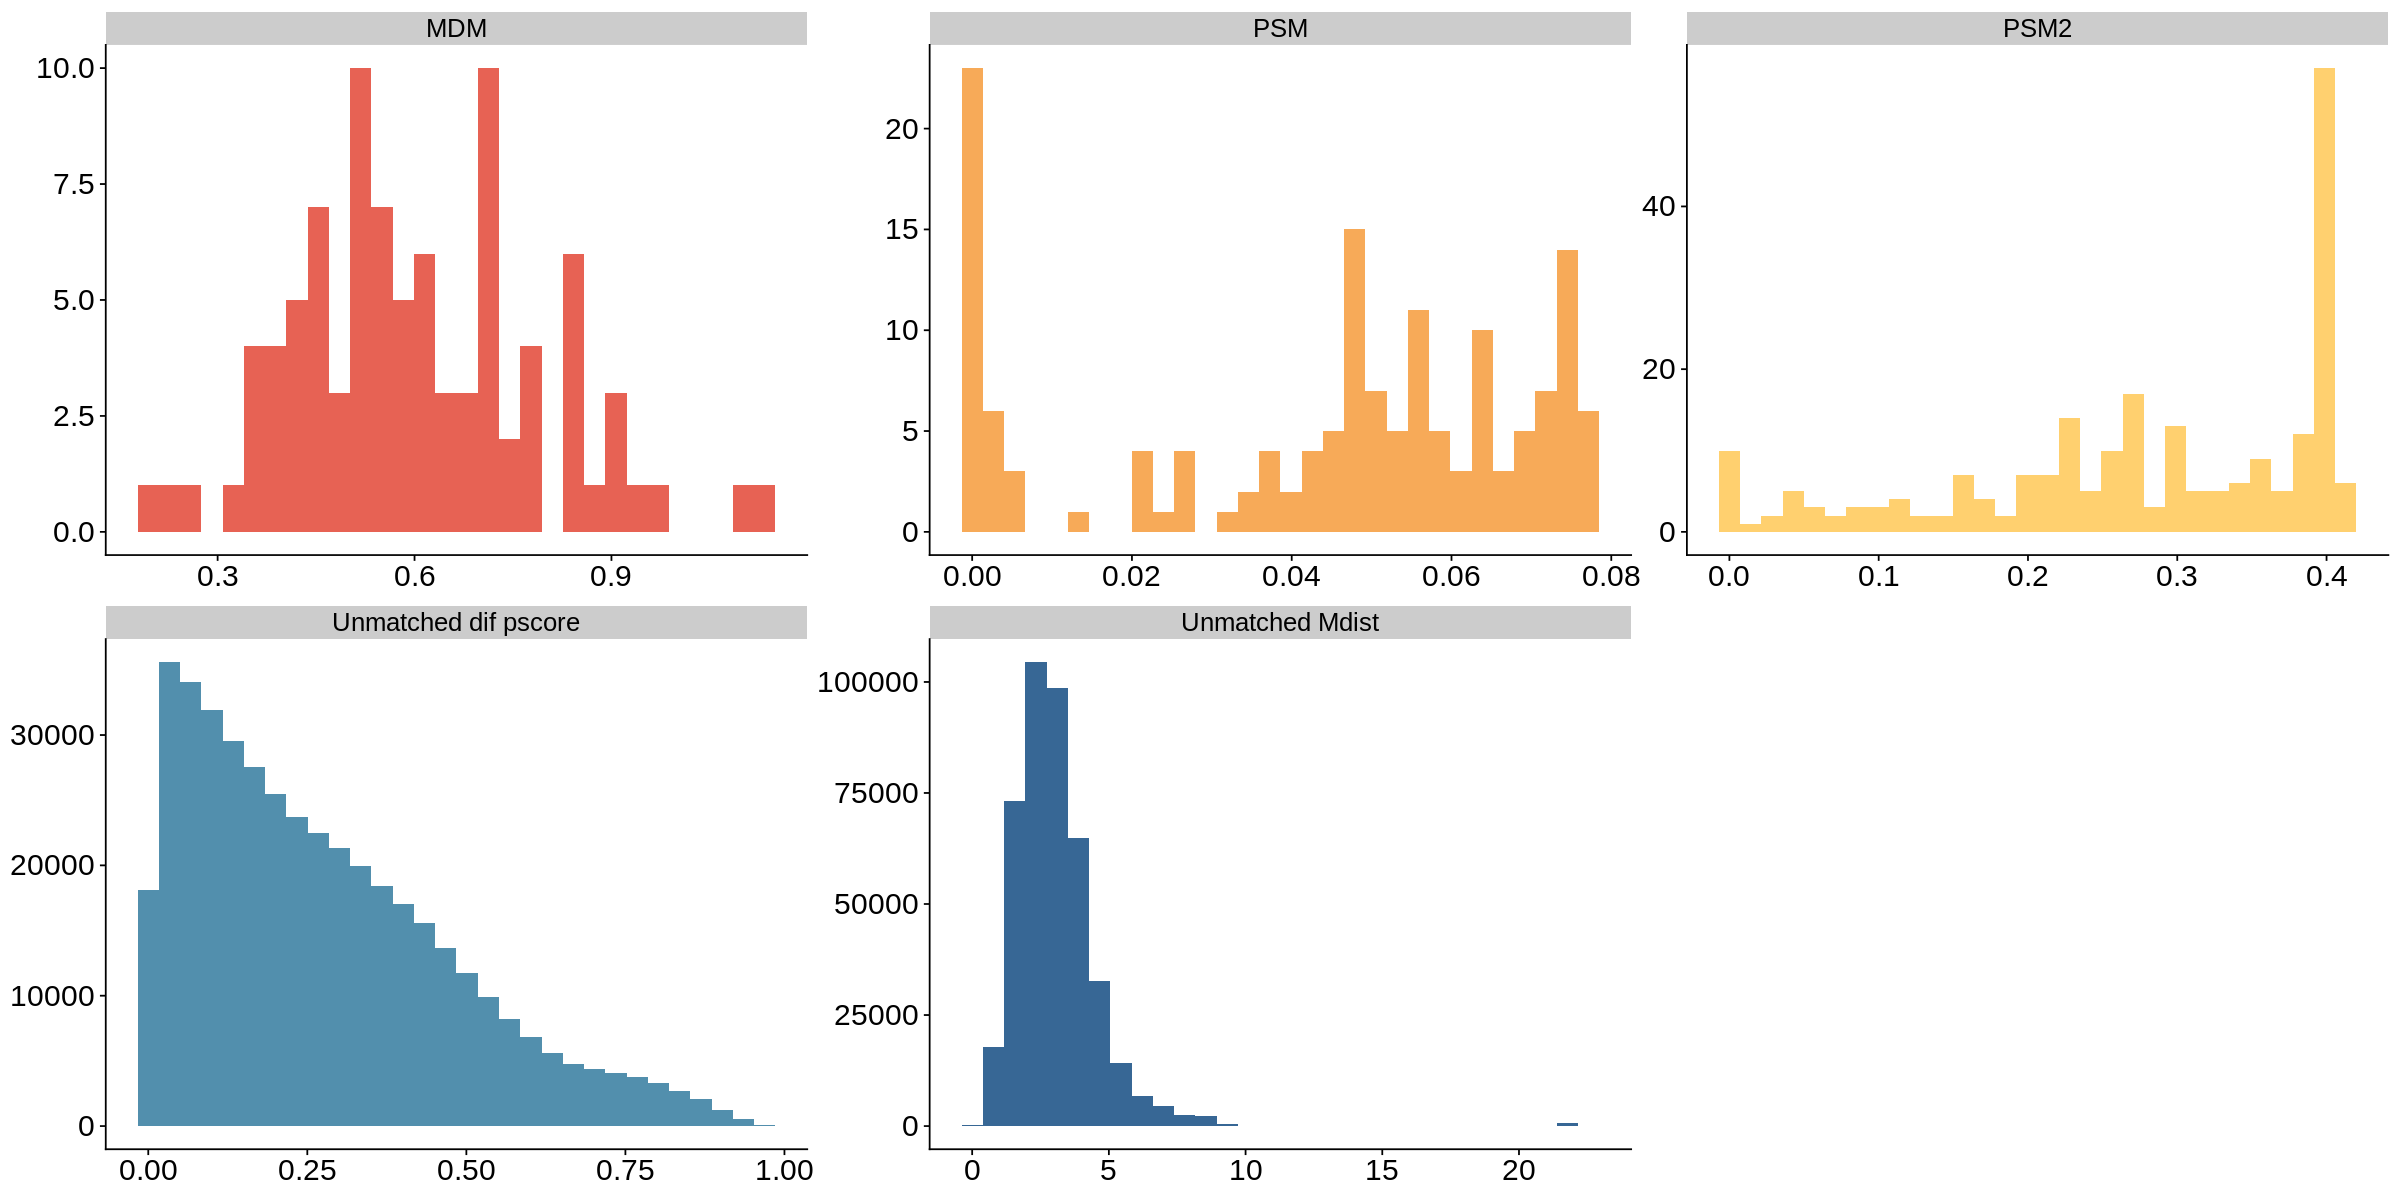

In [50]:
# What are the distnaces in the matched dataset? are they < THE RANGE? 
(dist_plt <-   ggplot() +
                     geom_histogram(data = dist, aes(distance, fill = dataset)) +
                     facet_wrap(~dataset, scales = 'free') +
                     scale_fill_manual(values = c(pal[1], pal[3], pal[4], pal[8], pal[9])) +
                     theme_cowplot() +
                     theme(text = element_text(size = 18),  
                     axis.title=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = 'none', legend.title = element_blank())
)

In [51]:
#ggsave(dist_plt, 'png', filename = 'figures/dist_plt.png', width = 20, height = 10)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



In [51]:
summary(mdm_pairs$distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2067  0.4629  0.5733  0.6032  0.7181  1.1459 

In [52]:
summary(round(psm_pairs$distance,3))
summary(psm_pairs2$distance)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02600 0.04900 0.04391 0.06400 0.07700 

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000026 0.2078133 0.3002504 0.2760145 0.3932768 0.4129384 

In [53]:
sd(pscore$pscore)
sd(pscore$pscore) * 0.25

[1] 0.2430687

[1] 0.06076717

# Variagrams - do plot measures correlate with distance 

In [54]:
mdist_grp_df <- m_dist_df %>%
            mutate(grp = cut(distance, seq(0.2,5,.2))) %>%
            left_join(pm_stand, by = c('cluster1' = 'plot_cluster')) %>%
            left_join(pm_stand, by = c('cluster2' = 'plot_cluster')) %>%
            transmute(pair, cluster1, cluster2, distance, grp,
                     diam_mean =  (diam_mean.x - diam_mean.y)^2,
                      stocking_ha = (stocking_ha.x - stocking_ha.y)^2, 
                      ba_ha = (ba_ha.x	- ba_ha.y)^2, #agb_ha = (agb_ha.x - agb_ha.y)^2,
                      richness  = (richness.x - richness.y)^2, shannon =  (shannon.x - shannon.y)^2, 
                      #simpson = (simpson.x - simpson.y)^2, 
                      hve_sp = (hve_sp.x - hve_sp.y)^2) %>%
            pivot_longer(diam_mean:hve_sp, names_to = 'variable', values_to = 'value') %>%
            drop_na() %>%
            group_by(grp, variable) %>%
            summarize(semi_var = (mean(value))*0.5, variance = var(value), mean_dist = mean(distance)) %>%
            mutate(dataset = 'MDM')

`summarise()` has grouped output by 'grp'. You can override using the `.groups` argument.



In [55]:
dpscore_grp_df <- dpscore_df %>%
            mutate(grp = cut(distance, seq(0,.4,0.02))) %>%
            left_join(pm_stand, by = c('cluster1' = 'plot_cluster')) %>%
            left_join(pm_stand, by = c('cluster2' = 'plot_cluster')) %>%
            transmute(pair, cluster1, cluster2, distance, grp,
                      diam_mean =  (diam_mean.x - diam_mean.y)^2,
                      stocking_ha = (stocking_ha.x - stocking_ha.y)^2, 
                      ba_ha = (ba_ha.x	- ba_ha.y)^2, #agb_ha = (agb_ha.x - agb_ha.y)^2,
                      richness  = (richness.x - richness.y)^2, shannon =  (shannon.x - shannon.y)^2, 
                      #simpson = (simpson.x - simpson.y)^2, 
                      hve_sp = (hve_sp.x - hve_sp.y)^2) %>%
            pivot_longer(diam_mean:hve_sp, names_to = 'variable', values_to = 'value') %>%
            drop_na() %>%
            group_by(grp, variable) %>%
            summarize(semi_var = (mean(value))*0.5, variance = var(value) * 0.5, mean_dist = mean(distance)) %>%
            mutate(dataset = 'PSM')

`summarise()` has grouped output by 'grp'. You can override using the `.groups` argument.



In [56]:
grp_dist_df <- bind_rows(mdist_grp_df, dpscore_grp_df)

In [57]:
##variance fro the whole 
dpscore_var <- dpscore_df %>%
            left_join(pm_stand, by = c('cluster1' = 'plot_cluster')) %>%
            left_join(pm_stand, by = c('cluster2' = 'plot_cluster')) %>%
            transmute(pair, cluster1, cluster2, distance,
                      diam_mean =  (diam_mean.x - diam_mean.y)^2,
                      stocking_ha = (stocking_ha.x - stocking_ha.y)^2, 
                      ba_ha = (ba_ha.x	- ba_ha.y)^2, #agb_ha = (agb_ha.x - agb_ha.y)^2,
                      richness  = (richness.x - richness.y)^2, shannon =  (shannon.x - shannon.y)^2, 
                      #simpson = (simpson.x - simpson.y)^2, 
                      hve_sp = (hve_sp.x - hve_sp.y)^2) %>%
            pivot_longer(diam_mean:hve_sp, names_to = 'variable', values_to = 'value') %>%
            drop_na() %>%
            group_by(variable) %>%
            summarize(semi_var = (mean(value))*0.5, variance = var(value) * 0.5, mean_dist = mean(distance))

In [58]:
##variance fro the whole 
mdist_var <- m_dist_df %>%
            left_join(pm_stand, by = c('cluster1' = 'plot_cluster')) %>%
            left_join(pm_stand, by = c('cluster2' = 'plot_cluster')) %>%
            transmute(pair, cluster1, cluster2, distance,
                      diam_mean =  (diam_mean.x - diam_mean.y)^2,
                      stocking_ha = (stocking_ha.x - stocking_ha.y)^2, 
                      ba_ha = (ba_ha.x	- ba_ha.y)^2, #agb_ha = (agb_ha.x - agb_ha.y)^2,
                      richness  = (richness.x - richness.y)^2, shannon =  (shannon.x - shannon.y)^2, 
                      #simpson = (simpson.x - simpson.y)^2, 
                      hve_sp = (hve_sp.x - hve_sp.y)^2) %>%
            pivot_longer(diam_mean:hve_sp, names_to = 'variable', values_to = 'value') %>%
            drop_na() %>%
            group_by(variable) %>%
            summarize(semi_var = (mean(value))*0.5, variance = var(value) * 0.5, mean_dist = mean(distance))

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



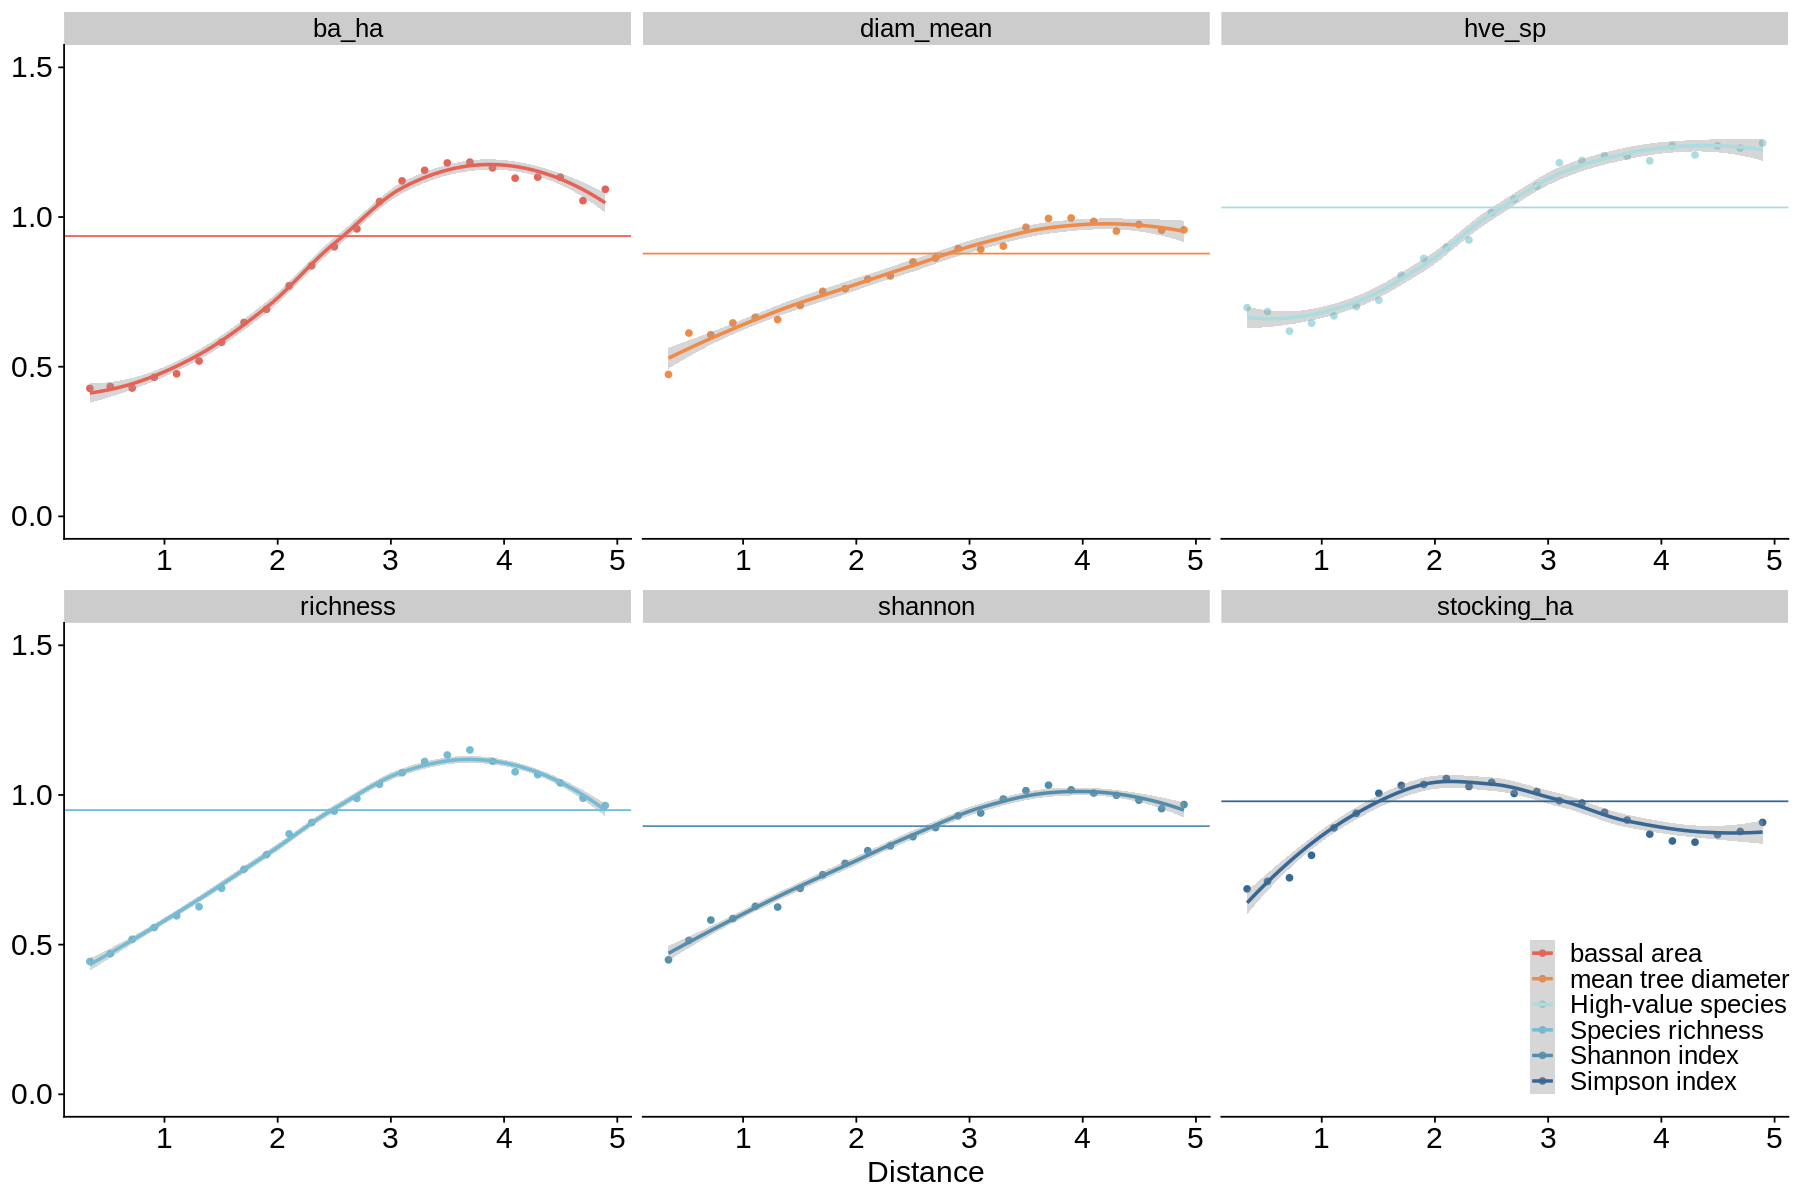

In [59]:
options(repr.plot.width=15, repr.plot.height=10)

(varigram_plt2 <- ggplot() +
    geom_point(data = mdist_grp_df, aes(x = mean_dist, y = semi_var, colour = variable)) +
    geom_smooth(data = mdist_grp_df, aes(x = mean_dist, y = semi_var, colour = variable)) +
    facet_wrap(~variable, scales = 'free_x') +
    geom_hline(data = mdist_var, aes(yintercept = semi_var, colour = variable)) +
    ylim(0,1.5) +
    theme_cowplot() +
    labs(x = 'Distance') +
    scale_colour_manual(values = c(pal[1],pal[2],pal[6],pal[7],pal[8],pal[9],pal[4]), 
                        labels = c('bassal area', 'mean tree diameter', 'High-value species', 'Species richness', 
                                                 'Shannon index', 'Simpson index', 'Stcoking Density')) +                     
    theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(.85,.1), legend.title = element_blank())
)

In [61]:
#ggsave(varigram_plt2, 'png', filename = 'figures/varigram_plt_mdist.png', width = 20, height = 10)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



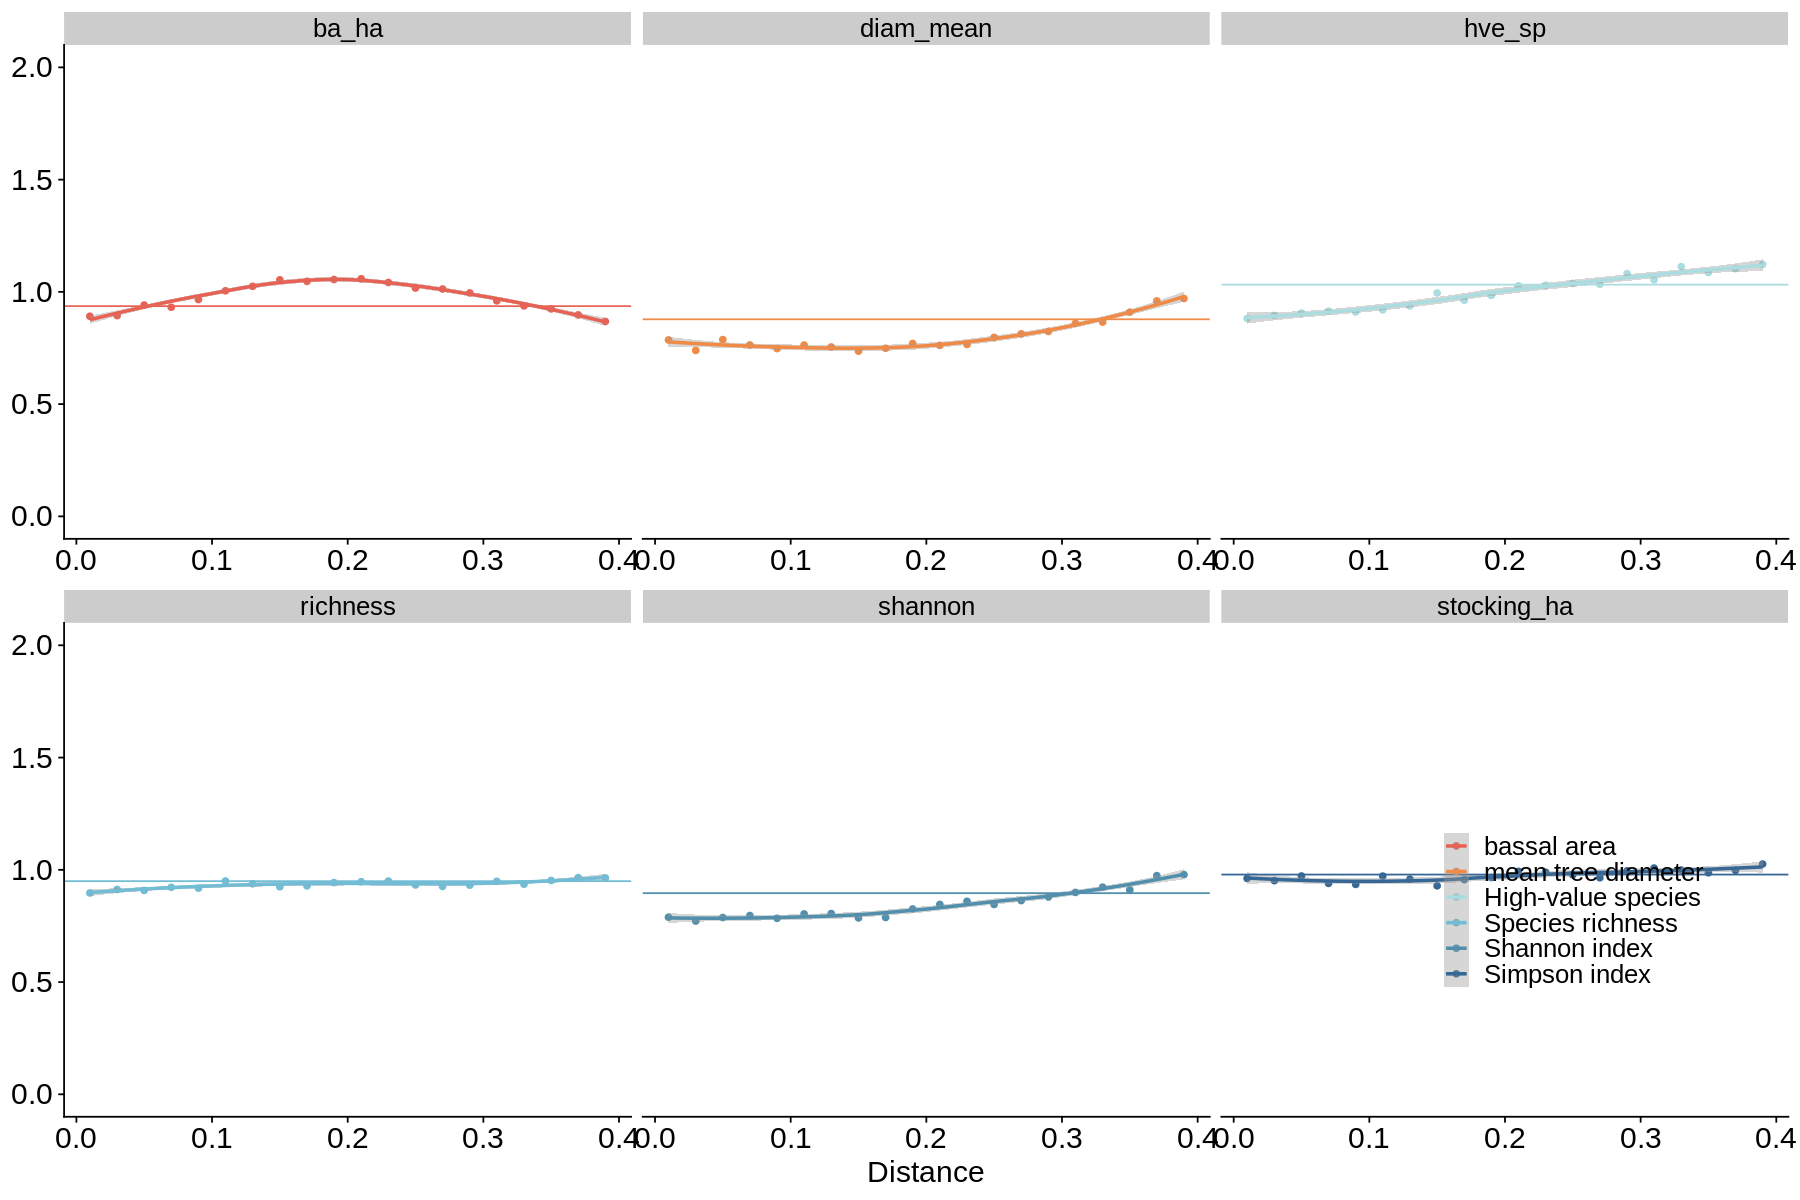

In [62]:
options(repr.plot.width=15, repr.plot.height=10)

(varigram_plt3 <- ggplot() +
    geom_point(data = dpscore_grp_df, aes(x = mean_dist, y = semi_var, colour = variable)) +
    geom_smooth(data = dpscore_grp_df, aes(x = mean_dist, y = semi_var, colour = variable)) +
    facet_wrap(~variable, scales = 'free_x') +
    geom_hline(data = dpscore_var, aes(yintercept = semi_var, colour = variable)) +
    ylim(0,2) +
    theme_cowplot() +
    labs(x = 'Distance') +
    scale_colour_manual(values = c(pal[1],pal[2],pal[6],pal[7],pal[8],pal[9],pal[4]), 
                        labels = c('bassal area', 'mean tree diameter', 'High-value species', 'Species richness', 
                                                 'Shannon index', 'Simpson index', 'Stcoking Density')) +                     
     theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(.8,.2), legend.title = element_blank())
)

In [63]:
ggsave(varigram_plt3, 'png', filename = 'figures/varigram_plt_pscore.png', width = 20, height = 10)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [64]:
dpscore_grp_df2 <- dpscore_df %>%
            mutate(grp = cut(distance, seq(0,.06,0.005))) %>%
            left_join(pm_stand, by = c('cluster1' = 'plot_cluster')) %>%
            left_join(pm_stand, by = c('cluster2' = 'plot_cluster')) %>%
            transmute(pair, cluster1, cluster2, distance, grp,
                      diam_mean =  (diam_mean.x - diam_mean.y)^2,
                      stocking_ha = (stocking_ha.x - stocking_ha.y)^2, 
                      ba_ha = (ba_ha.x	- ba_ha.y)^2, #agb_ha = (agb_ha.x - agb_ha.y)^2,
                      richness  = (richness.x - richness.y)^2, shannon =  (shannon.x - shannon.y)^2, 
                      #simpson = (simpson.x - simpson.y)^2, 
                      hve_sp = (hve_sp.x - hve_sp.y)^2) %>%
            pivot_longer(diam_mean:hve_sp, names_to = 'variable', values_to = 'value') %>%
            drop_na() %>%
            group_by(grp, variable) %>%
            summarize(semi_var = (mean(value))*0.5, numb_pairs = length(variable), variance = var(value) * 0.5, mean_dist = mean(distance)) %>%
            mutate(dataset = 'PSM')

`summarise()` has grouped output by 'grp'. You can override using the `.groups` argument.



`geom_smooth()` using method = 'loess' and formula 'y ~ x'



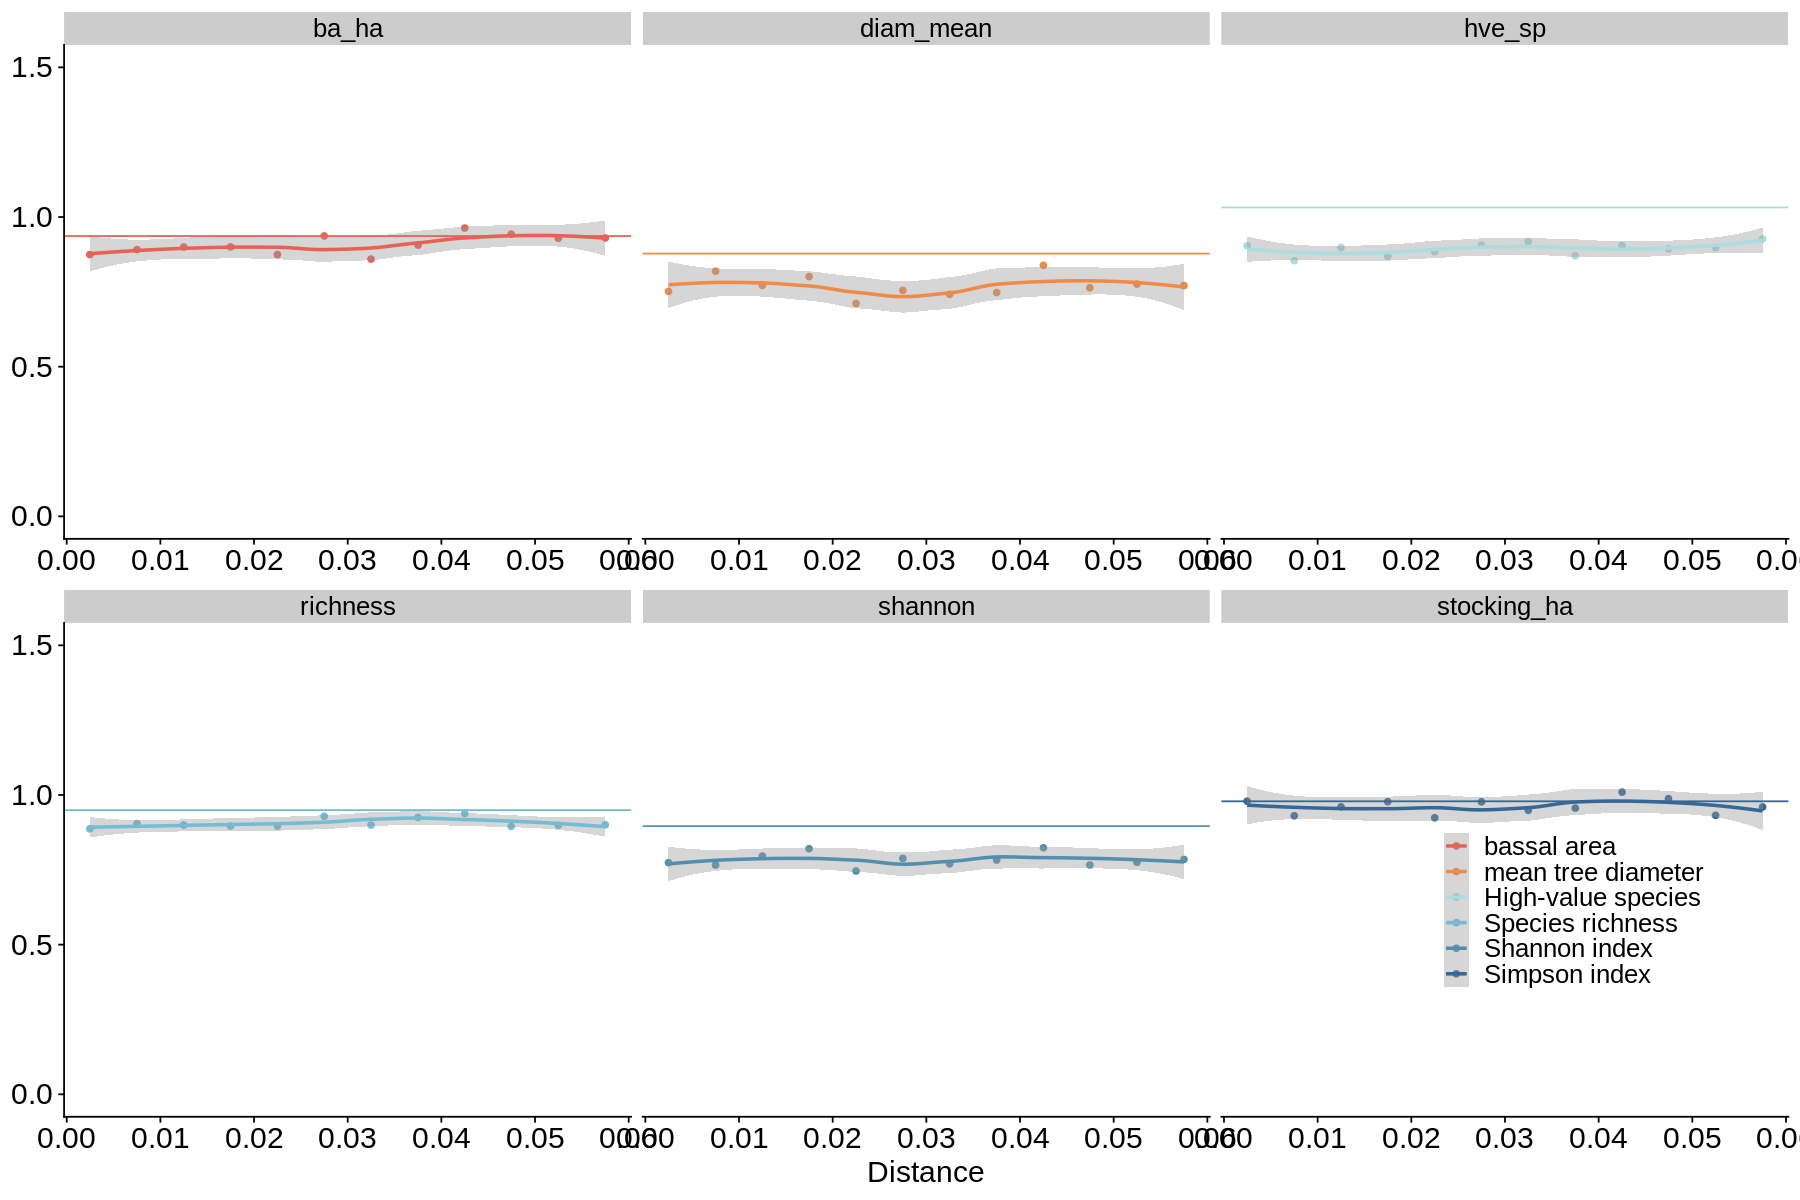

In [65]:
options(repr.plot.width=15, repr.plot.height=10)

(varigram_plt4 <- ggplot() +
    geom_point(data = dpscore_grp_df2, aes(x = mean_dist, y = semi_var, colour = variable)) +
    geom_smooth(data = dpscore_grp_df2, aes(x = mean_dist, y = semi_var, colour = variable)) +
     geom_hline(data = dpscore_var, aes(yintercept = semi_var, colour = variable)) +

    facet_wrap(~variable, scales = 'free_x') +
    ylim(0,1.5) +
    theme_cowplot() +
    labs(x = 'Distance') +
    scale_colour_manual(values = c(pal[1],pal[2],pal[6],pal[7],pal[8],pal[9],pal[4]), 
                        labels = c('bassal area', 'mean tree diameter', 'High-value species', 'Species richness', 
                                                 'Shannon index', 'Simpson index', 'Stcoking Density')) +                     
     theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(.8,.2), legend.title = element_blank())
)

In [66]:
#ggsave(varigram_plt4, 'png', filename = 'figures/varigram_plt_pscore_shrt_np.png', width = 20, height = 10)

In [67]:
##beta diverity in distance groups
mdist_grp_beta_df <- m_dist_df %>%
            mutate(m_dist_grp = cut(distance, seq(0.2,5,.2))) %>% 
            left_join(select(beta_all_df, pair, bray_curtis), by = 'pair') %>%           
            drop_na() %>%
            group_by(m_dist_grp) %>%
            summarize(mean_bc = mean(bray_curtis), se = sd(bray_curtis)/sqrt(length(bray_curtis)), mean_dist = mean(distance)) %>%
            mutate(dataset = 'MDM')

In [68]:
##beta diverity in distance groups
dpscore_grp_beta_df <- dpscore_df %>%
            mutate(dpscore_grp = cut(distance, seq(0,.4,0.02))) %>%
            left_join(select(beta_all_df, pair, bray_curtis), by = 'pair') %>%           
            drop_na() %>%
            group_by(dpscore_grp) %>%
            summarize(mean_bc = mean(bray_curtis), se = sd(bray_curtis)/sqrt(length(bray_curtis)), mean_dist = mean(distance)) %>%
            mutate(dataset = 'PSM')

In [69]:
grp_beta_comp <- bind_rows(mdist_grp_beta_df, dpscore_grp_beta_df)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



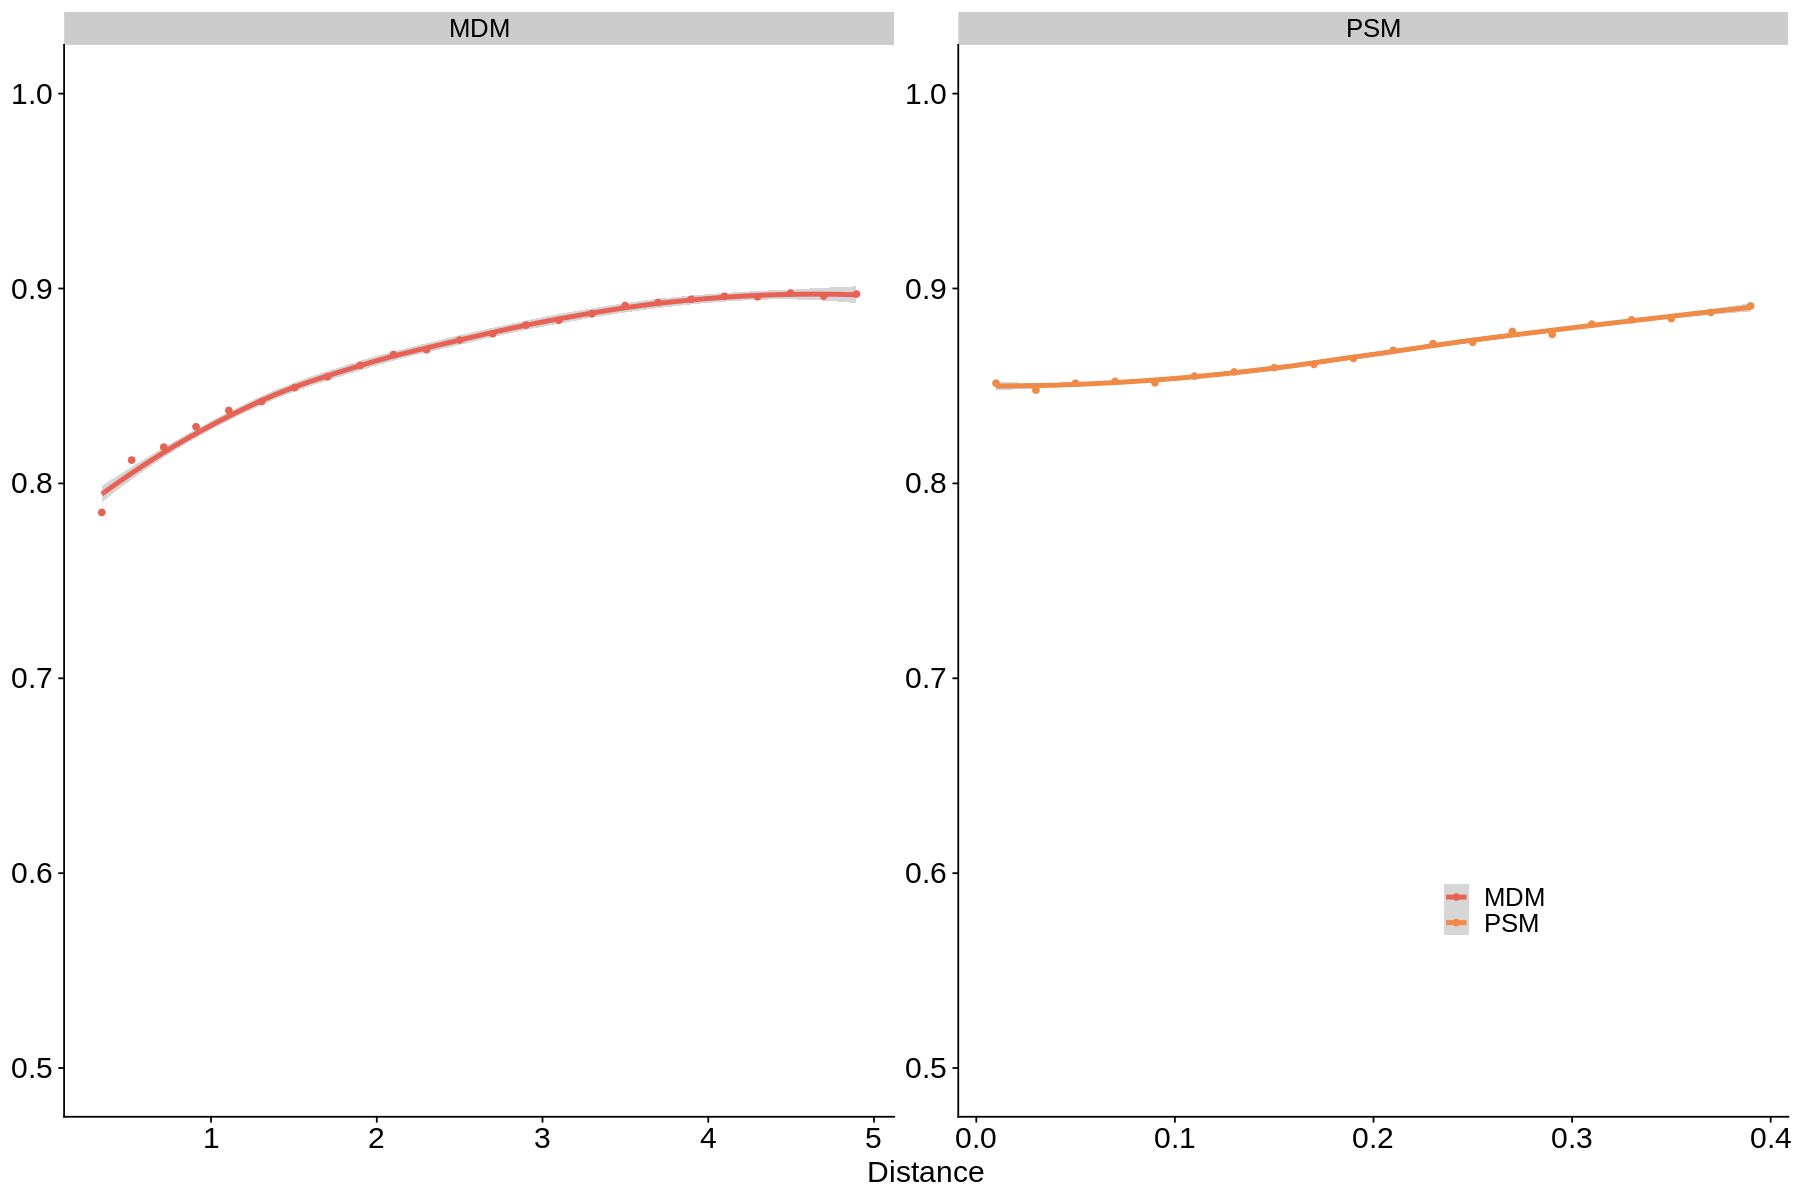

In [70]:
(beta_vrgm_plt <- ggplot() +
                geom_smooth(data = grp_beta_comp, aes(x = mean_dist, y = mean_bc, colour = dataset), size = 1.4) +
                geom_point(data = grp_beta_comp, aes(x = mean_dist, y = mean_bc, colour = dataset)) +
                facet_wrap(~dataset, scales = 'free') +
                ylim(0.5,1) +
                theme_cowplot() + 
                 labs(x = 'Distance') +
                scale_colour_manual(values = pal) +
                     theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = c(.8,.2), legend.title = element_blank())
 )

In [71]:
ggsave(beta_vrgm_plt, 'png', filename = 'figures/beta_vrgm_plt.png', width = 20, height = 10)

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



# How balanced are the matched datasets using plot measurements?

In [60]:
psm_pm <- psm %>%
            select(plot_cluster, treatment, subclass) %>%
            left_join(plt_ms, by = 'plot_cluster')

In [61]:
psm2_pm <- psm2 %>%
            select(plot_cluster, treatment, subclass) %>%
            left_join(plt_ms, by = 'plot_cluster')

In [62]:
mdm_pm <- mdm %>%
            select(plot_cluster, treatment, subclass) %>%
            left_join(plt_ms, by = 'plot_cluster')

In [63]:
unm_pm <- unm %>%
            select(plot_cluster, treatment) %>%
            left_join(plt_ms, by = 'plot_cluster')

In [64]:
##get the square root of the average of the variances within each treatment group
psm_sd <-psm_pm %>%
            group_by(treatment) %>%
            select(treatment, stocking_ha, ba_ha, diam_mean, richness, shannon, hve_sp) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(treatment, metric) %>%
            summarize(var = var(value)) %>%
            ungroup() %>%
            group_by(metric) %>%
            summarize(sd_fac = sqrt(mean(var)))

`summarise()` has grouped output by 'treatment'. You can override using the `.groups` argument.



In [65]:
##get the square root of the average of the variances within each treatment group
psm2_sd <-psm2_pm %>%
            group_by(treatment) %>%
            select(treatment, stocking_ha, ba_ha, diam_mean, richness, shannon, hve_sp) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(treatment, metric) %>%
            summarize(var = var(value)) %>%
            ungroup() %>%
            group_by(metric) %>%
            summarize(sd_fac = sqrt(mean(var)))

`summarise()` has grouped output by 'treatment'. You can override using the `.groups` argument.



In [66]:
##get the square root of the average of the variances within each treatment group
mdm_sd <-mdm_pm %>%
            group_by(treatment) %>%
            select(treatment, stocking_ha, ba_ha, diam_mean, richness, shannon, hve_sp) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(treatment, metric) %>%
            summarize(var = var(value)) %>%
            ungroup() %>%
            group_by(metric) %>%
            summarize(sd_fac = sqrt(mean(var)))

`summarise()` has grouped output by 'treatment'. You can override using the `.groups` argument.



In [67]:
##get the square root of the average of the variances within each treatment group
unm_sd <- unm_pm %>%
            group_by(treatment) %>%
            select(treatment, stocking_ha, ba_ha, diam_mean, richness, shannon, hve_sp) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(treatment, metric) %>%
            summarize(var = var(value)) %>%
            ungroup() %>%
            group_by(metric) %>%
            summarize(sd_fac = sqrt(mean(var)))

`summarise()` has grouped output by 'treatment'. You can override using the `.groups` argument.



In [68]:
## calcualte SMD for plot measurments - PSM dataset
smd_psm <- psm_pm %>%
            group_by(treatment) %>%
            summarize(across(.cols = stocking_ha:hve_sp, mean)) %>%
            ungroup() %>%
            summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
            pivot_longer(cols = everything(), names_to = 'metric', values_to = 'mean_dif') %>%
            left_join(psm_sd, by = 'metric') %>%
            mutate(smd = mean_dif / sd_fac,  dataset = 'PSM') 

In [69]:
## calcualte SMD for plot measurments - PSM dataset
smd_psm2 <- psm2_pm %>%
            group_by(treatment) %>%
            summarize(across(.cols = stocking_ha:hve_sp, mean)) %>%
            ungroup() %>%
            summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
            pivot_longer(cols = everything(), names_to = 'metric', values_to = 'mean_dif') %>%
            left_join(psm2_sd, by = 'metric') %>%
            mutate(smd = mean_dif / sd_fac,  dataset = 'PSM2') 

In [70]:
## calcualte SMD for plot measurments - PSM dataset
smd_mdm <- mdm_pm %>%
            group_by(treatment) %>%
            summarize(across(.cols = stocking_ha:hve_sp, mean)) %>%
            ungroup() %>%
            summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
            pivot_longer(cols = everything(), names_to = 'metric', values_to = 'mean_dif') %>%
            left_join(mdm_sd, by = 'metric') %>%
            mutate(smd = mean_dif / sd_fac,  dataset = 'MDM') 

In [71]:
## calcualte SMD for plot measurments - unmatched dataset
smd_umn <- unm_pm %>%
            group_by(treatment) %>%
            summarize(across(.cols = stocking_ha:hve_sp, mean)) %>%
            ungroup() %>%
            summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
            pivot_longer(cols = everything(), names_to = 'metric', values_to = 'mean_dif') %>%
            left_join(unm_sd, by = 'metric') %>%
            mutate(smd = mean_dif / sd_fac,  dataset = 'Unmatched') 

In [72]:
##join the two datasets together
smd_df <- bind_rows(smd_umn, smd_psm, smd_mdm, smd_psm2)

## Compared with random

In [73]:
##get the square root of the average of the variances within each treatment group
ran_sd <- randoms %>%
            select(plot_cluster, dataset) %>%
            left_join(unm_pm, by = 'plot_cluster') %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(dataset, treatment, metric) %>%
            summarize(var = var(value)) %>%
            ungroup() %>%
            group_by(dataset, metric) %>%
            summarize(sd_fac = sqrt(mean(var)))

`summarise()` has grouped output by 'dataset', 'treatment'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



In [74]:
## calcualte SMD for plot measurments - unmatched dataset
smd_ran <- randoms %>%
            select(plot_cluster, dataset) %>%
            left_join(unm_pm, by = 'plot_cluster') %>%
            group_by(dataset, treatment) %>%
            summarize(across(.cols = stocking_ha:hve_sp, mean)) %>%
            ungroup() %>%
            group_by(dataset) %>%
            summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'mean_dif') %>%
            left_join(ran_sd, by = c('dataset', 'metric')) %>%
            mutate(smd = mean_dif / sd_fac)

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



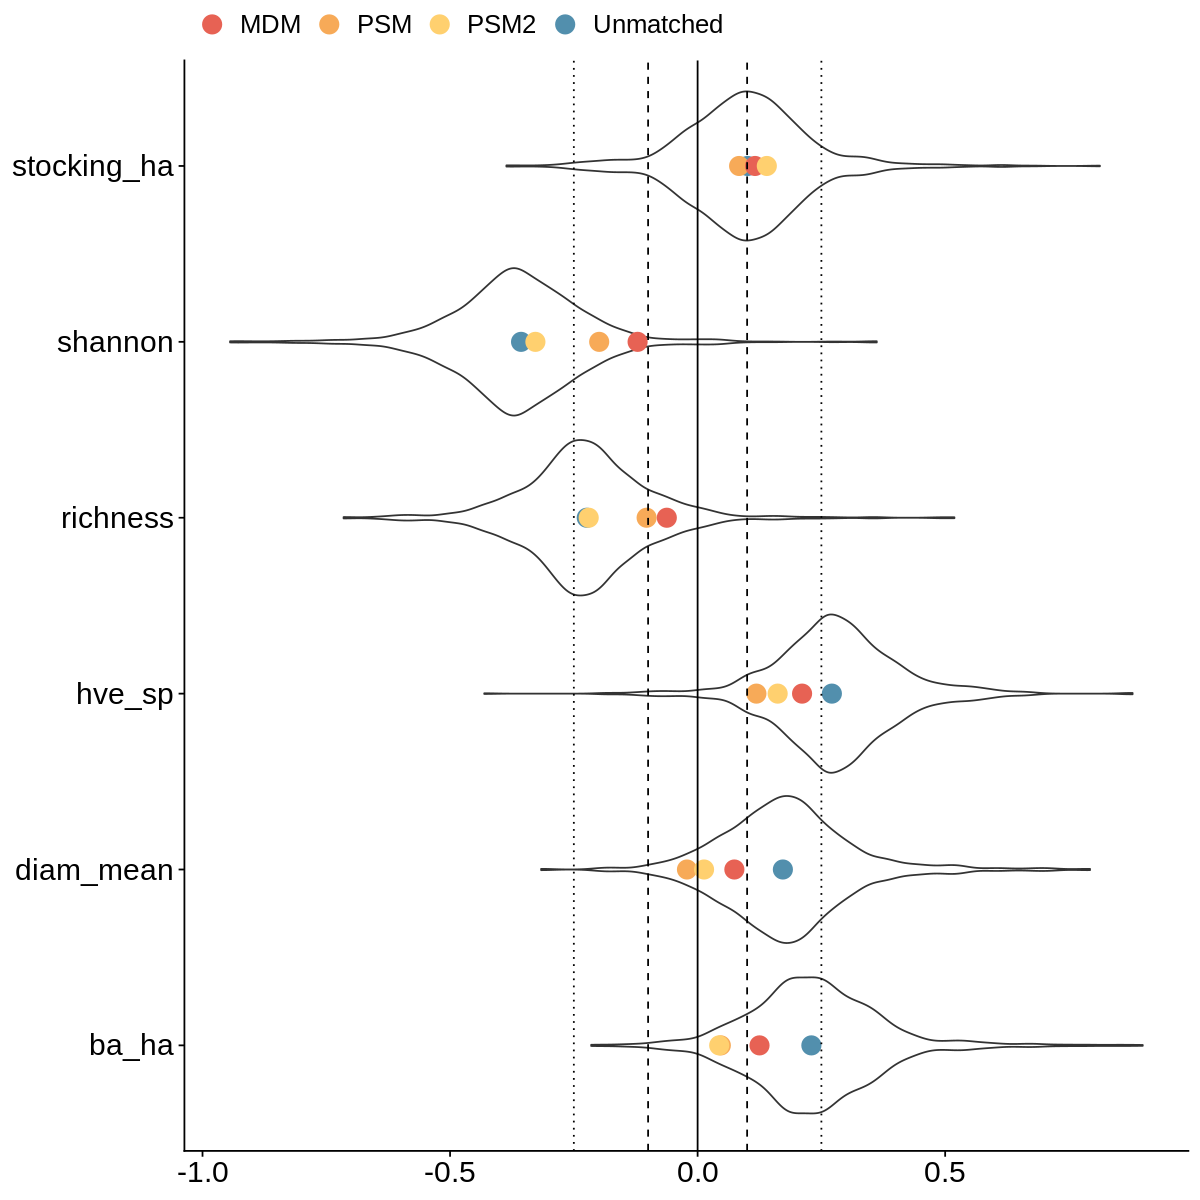

In [75]:
##produce plot of smds for all match years 
##plot ofthe smd for each confounder before and after the match, the 'distacne' measure is the propensity score
options(repr.plot.width=10, repr.plot.height=10)

(smd_plot <- ggplot() + 
            geom_violin(data = smd_ran, aes(metric, smd)) +
            geom_point(data = smd_df, aes(metric, smd, colour = dataset), size = 5) +
            geom_hline(yintercept = 0) + 
            geom_hline(yintercept = -0.1, linetype = 'dashed') + geom_hline(yintercept = 0.1, linetype = 'dashed') +
            geom_hline(yintercept = -0.25, linetype = 'dotted') + geom_hline(yintercept = 0.25, linetype = 'dotted') +
            coord_flip() +
            theme_cowplot() +
            scale_colour_manual(values = c(pal[1], pal[3], pal[4], pal[8])) +
            theme(text = element_text(size = 18),  
                     axis.title=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position = 'top', legend.title = element_blank())
)

In [200]:
smd_ran2 <- smd_ran %>%
                group_by(metric) %>%
                summarize(mean_smd = mean(smd), sd_smd = sd(smd), n = length(smd), 
                          lo95 = mean_smd - (1.96 * sd_smd), up95 = mean_smd + (1.96 * sd_smd))

In [201]:
smd_ran2

metric,mean_smd,sd_smd,n,lo95,up95
<chr>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
ba_ha,0.23423999,0.1345422,1000,-0.02946272,0.49794270
diam_mean,0.17788077,0.1334966,1000,-0.08377262,0.43953415
hve_sp,0.27921633,0.1267176,1000,0.03084985,0.52758280
richness,-0.22564177,0.1322879,1000,-0.48492609,0.03364254
shannon,-0.36096329,0.1366456,1000,-0.62878863,-0.09313795
stocking_ha,0.09833195,0.1291370,1000,-0.15477662,0.35144053


In [202]:
m

[1] "hve_sp"

In [203]:
x <-  smd_ran %>% filter(metric == m) %>% select(smd)
mu <- smd_df %>% filter(dataset == d & metric == m) %>% select(smd) %>% as.numeric()
x1 <- smd_ran2 %>% filter(metric == m)

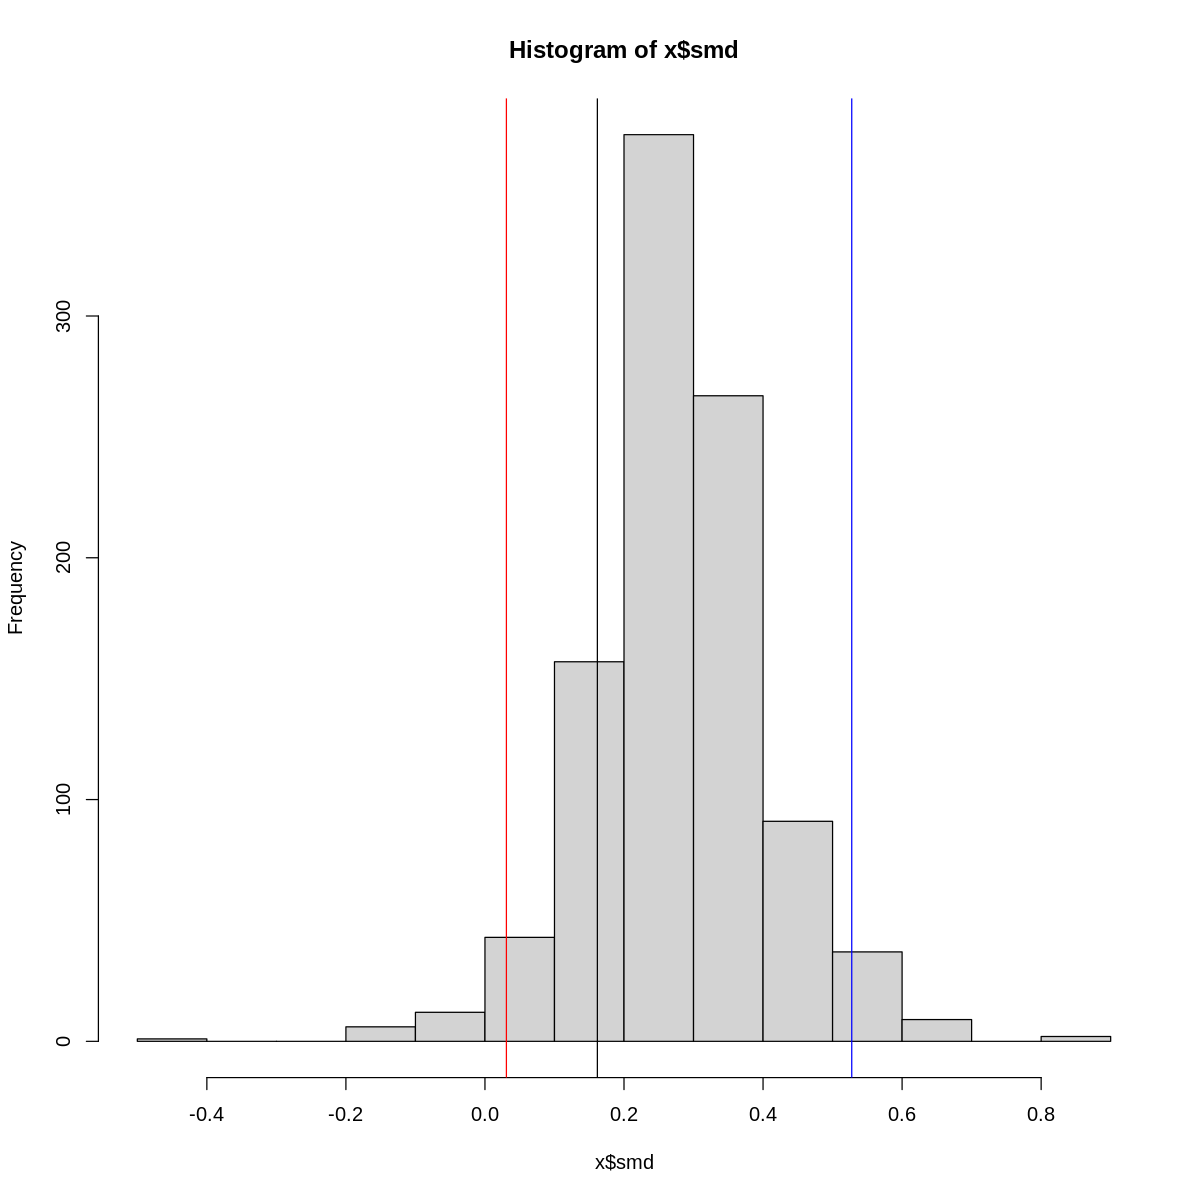

In [204]:
hist(x$smd)
abline(v = mu)
abline(v = x1$lo95, col = 'red')
abline(v = x1$up95, col = 'blue')

In [153]:
##is the smd of the matched dataset with the 95% CIS of the random datasets? 

dataset = unique(smd_df$dataset)
metrics = unique(smd_df$metric)
t_df <- data.frame()

for(d in dataset) {
    for(m in metrics){
        mu <- smd_df %>% filter(dataset == d & metric == m) %>% select(smd) %>% as.numeric()
        y <- smd_ran %>% filter(metric == m) %>% select(smd)
        t <- t.test(x = y, mu = mu)
        t_df1 <- data.frame(dataset = d, metric = m, t.stat = t$statistic, p.value = round(t$p.value,4), 
                    estimate = t$estimate, conf_lo =  t$conf.int[1], conf_up = t$conf.int[2])
        t_df = bind_rows(t_df, t_df1)
        
    }}

In [154]:
t_df

,dataset,metric,t.stat,p.value,estimate,conf_lo,conf_up
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
t...1,Unmatched,stocking_ha,-0.6151426,0.5386,0.09833195,0.0903184,0.1063455
t...2,Unmatched,ba_ha,1.0500934,0.2939,0.23423999,0.2258910,0.2425890
t...3,Unmatched,diam_mean,1.3402325,0.1805,0.17788077,0.1695967,0.1861649
t...4,Unmatched,richness,-0.4121142,0.6803,-0.22564177,-0.2338509,-0.2174327
t...5,Unmatched,shannon,-1.0034224,0.3159,-0.36096329,-0.3694428,-0.3524838
t...6,Unmatched,hve_sp,2.0077193,0.0449,0.27921633,0.2713529,0.2870797
t...7,PSM,stocking_ha,3.5555571,0.0004,0.09833195,0.0903184,0.1063455
t...8,PSM,ba_ha,44.0351327,0.0000,0.23423999,0.2258910,0.2425890
t...9,PSM,diam_mean,47.2302026,0.0000,0.17788077,0.1695967,0.1861649


In [88]:
#ggsave(smd_plot, 'png', filename = 'figures/pm_smd_plt_np.png', width = 10, height = 10)

# How different are the matched pairs in terms of plot measurements?

## differences between pairs - absolute differnces

In [155]:
##difference in plot measurements for matched pairs - PSM dataset (also calculate difference in p_score)
psm_dif <- psm %>%
            select(plot_cluster, treatment, subclass, pscore) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            group_by(subclass) %>%
            arrange(treatment) %>%
            #summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%  ##this is treatment - control
            summarize(across(.cols = stocking_ha:hve_sp, ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            mutate(dataset = 'PSM')

In [156]:
##difference in plot measurements for matched pairs - PSM dataset (also calculate difference in p_score)
psm2_dif <- psm2 %>%
            select(plot_cluster, treatment, subclass, pscore) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            group_by(subclass) %>%
            arrange(treatment) %>%
            #summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%  ##this is treatment - control
            summarize(across(.cols = stocking_ha:hve_sp, ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            mutate(dataset = 'PSM2')

In [157]:
##difference in plot elvel charatrics and matched pairs (and join the Malhanbois distance between pairs)
mdm_dif <- mdm %>%
            select(plot_cluster, treatment, subclass) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            group_by(subclass) %>%
            arrange(treatment) %>%
            #summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%  ##this is treatment - control
            summarize(across(.cols = stocking_ha:hve_sp, ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            mutate(dataset = 'MDM')

In [172]:
##difference in plot elvel charatrics and matched pairs (and join the Malhanbois distance between pairs)
ran_dif <- randoms %>%
            arrange(treatment) %>%
            select(dataset, plot_cluster, subclass) %>%
            left_join(pm_stand, by = 'plot_cluster') %>%
            group_by(dataset, subclass) %>%
            #summarize(across(.cols = stocking_ha:hve_sp, ~ (last(.x) - first(.x)))) %>%  ##this is treatment - control
            summarize(across(.cols = stocking_ha:hve_sp, ~ abs((last(.x) - first(.x))))) %>%  ##this is treatment - control
            ungroup() %>%
            left_join(ran_pairs, by = c('dataset','subclass')) %>%
            distinct(.,pair, .keep_all = TRUE) %>%
            pivot_longer(cols = stocking_ha:hve_sp, names_to = 'metric', values_to = 'value') %>%
            group_by(dataset, metric) %>%
            summarize(value = mean(value), se = sd(value)/sqrt(length(value))) %>%
            mutate(dataset = 'random') %>%
            ungroup()

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



In [159]:
dif_compare2 <- bind_rows(psm_dif, mdm_dif, psm2_dif) %>%
                    group_by(dataset, metric) %>%
                    summarize(mean = mean(value), se = sd(value)/sqrt(length(value)))

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.



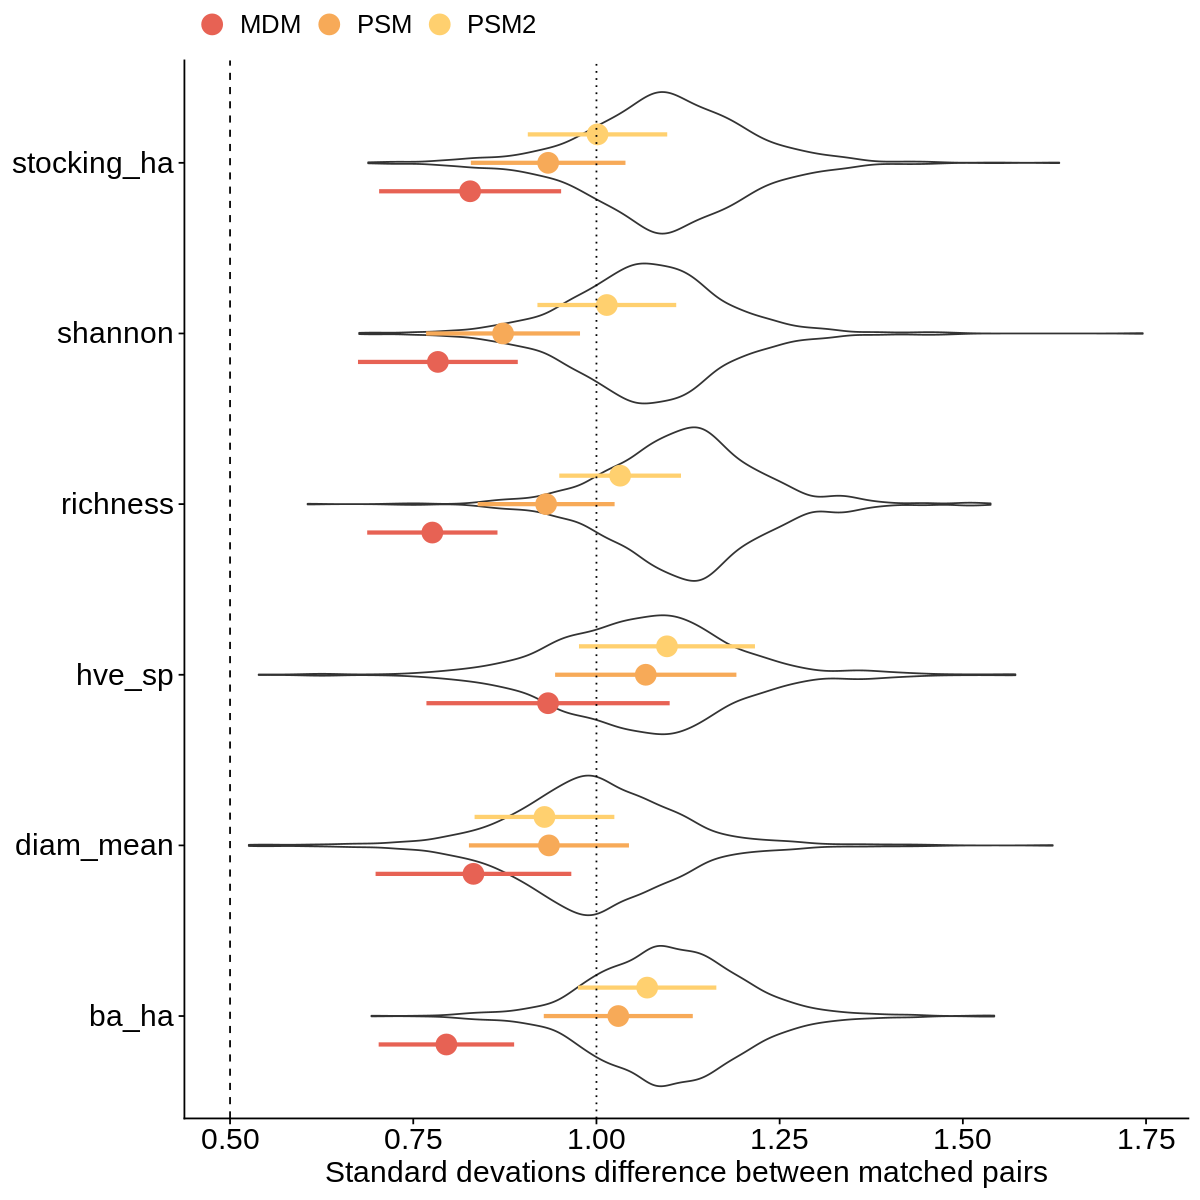

In [173]:
options(repr.plot.width=10, repr.plot.height=10)

(pair_dif_plot <- ggplot() + 
                     geom_violin(data = ran_dif, aes(metric, value)) +

                    geom_pointrange(data = dif_compare2, 
                                    aes(x = metric, y = mean, ymin = mean -(1.96*se), ymax = mean + (se*1.96), colour = dataset),
                                       position = position_dodge(width =0.5), size = 1.2) + 
                    coord_flip() +
                    #geom_hline(yintercept =0)  +
                    geom_hline(yintercept = 0.5, linetype="dashed") +
                    geom_hline(yintercept = 1, linetype="dotted") +
                    labs(y='Standard devations difference between matched pairs') +
                    theme_cowplot() +
                    scale_colour_manual(values = c(pal[1], pal[3], pal[4], pal[8])) +
                    theme(text = element_text(size = 18),  
                     axis.title.y=element_blank(), 
                     axis.text=element_text(size = 18),
                     legend.position ='top', legend.title = element_blank())
 )

In [163]:
##coma
dif_comp_dist <- bind_rows(psm_dif, mdm_dif, psm2_dif)

In [177]:
dataset = unique(dif_comp_dist$dataset)
metrics = unique(dif_comp_dist$metric)
t_dif_df <- data.frame()

for(d in dataset) {
    for(m in metrics){
        y1 <- dif_comp_dist %>% filter(dataset == d & metric == m) %>% select(value)
        y2 <- rans_dif %>% filter(metric == m) %>% select(value)
        t <- t.test(y1, y2, mu = mu)
        t_dif_df1 <- data.frame(dataset = d, metric = m, t.stat = t$statistic, p.value = round(t$p.value,4))
        t_dif_df = bind_rows(t_dif_df, t_dif_df1)
        
    }}

In [178]:
t_dif_df

,dataset,metric,t.stat,p.value
,<chr>,<chr>,<dbl>,<dbl>
t...1,PSM,stocking_ha,-6.014190,0.0000
t...2,PSM,ba_ha,-4.468383,0.0000
t...3,PSM,diam_mean,-4.003811,0.0001
t...4,PSM,richness,-7.320786,0.0000
t...5,PSM,shannon,-6.711547,0.0000
t...6,PSM,hve_sp,-2.535760,0.0118
t...7,MDM,stocking_ha,-6.790634,0.0000
t...8,MDM,ba_ha,-9.875124,0.0000
t...9,MDM,diam_mean,-4.786189,0.0000


In [97]:
#ggsave(pair_dif_plot, 'png', filename = 'figures/pm_pair_dif_plt_np.png', width = 20, height = 10)

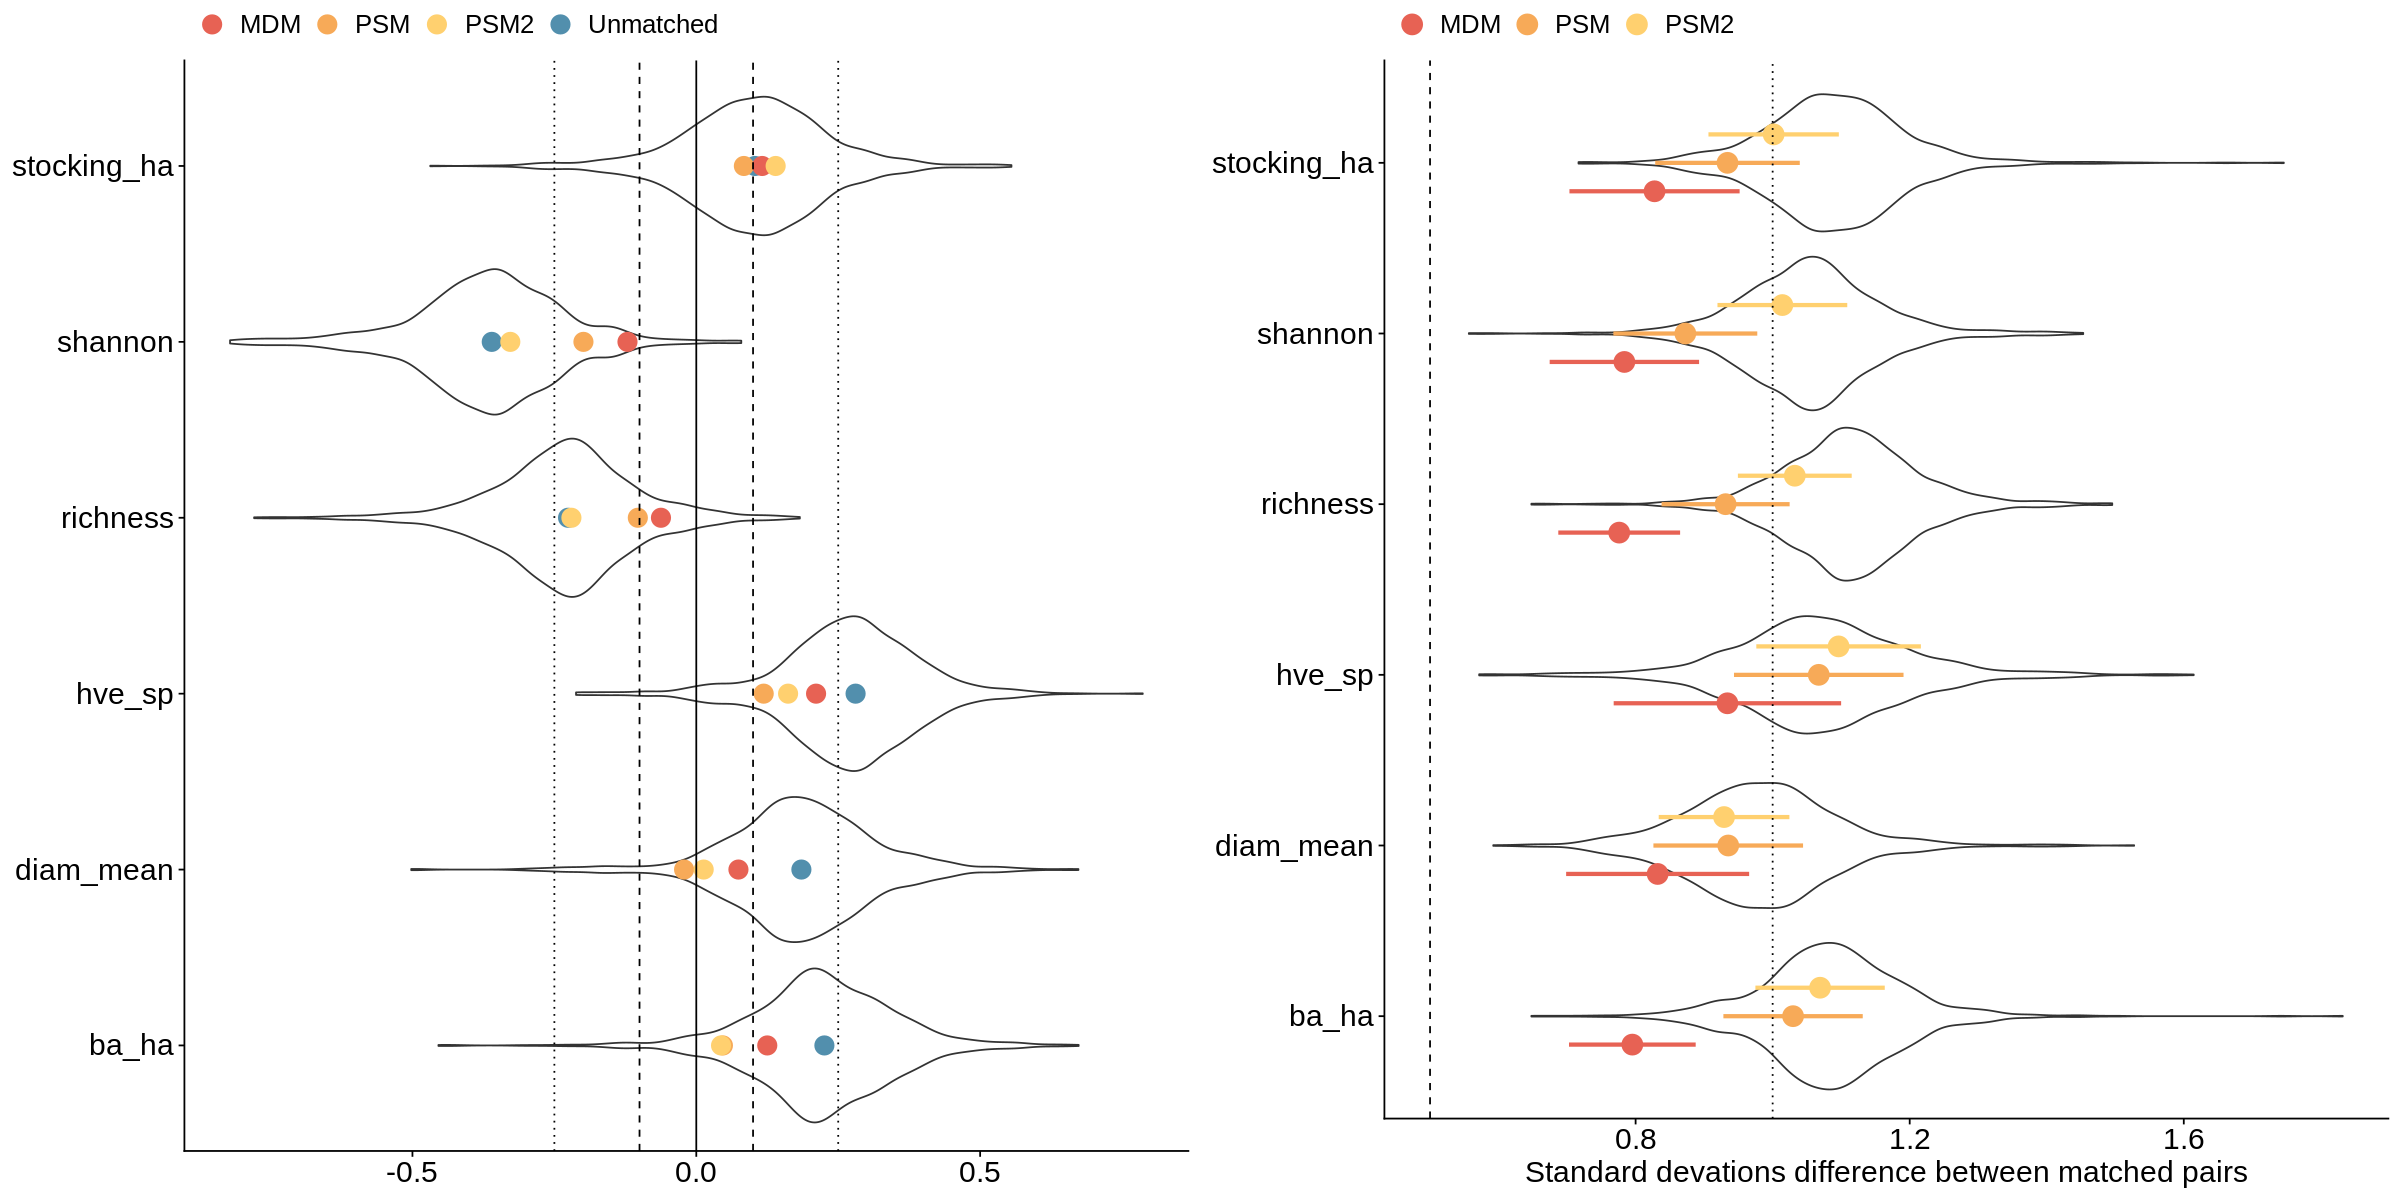

In [98]:
options(repr.plot.width=20, repr.plot.height=10)

dif_grid <-  plot_grid(smd_plot, pair_dif_plot)
dif_grid

In [99]:
ggsave(dif_grid, 'png', filename = 'figures/pair_dif&smd_plt.png', width = 20, height = 10)